# Analysis of Text Matching Data Generated from JSTOR Dataset 

- [Generating *Middlemarch* chapter and book locations](#Generating-Middlemarch-chapter-and-book-locations)
- [Statistics on our JSTOR dataset](#Statistics-on-our-dataset-of-JSTOR-matches)
    - [Data Dictionary for text matcher dataset](#Data-Dictionary-for-text-matcher-dataset)
    - [How many quotations do we have?](#How-many-quotations-do-we-have?)
    - [How many total articles do we have?](#How-many-total-articles-do-we-have?)
    - [How many articles with matches do we have?](#How-many-articles-with-matches-do-we-have?)
    - [How many articles do we have published in each year?](#How-many-articles-do-we-have-published-in-each-year?)
    - [Number of non-matches in the 6,069-article dataset](#Number-of-non-matches-in-the-6,069-article-dataset)
    - [Average numbers of quoted words per item](#Average-numbers-of-quoted-words-per-item)
    - [Average numbers of quoted words per match, per item](#Average-number-of-words-per-match,-per-item)
    - [Quotation length statistics](#Quotation-Length-Statistics)
- [Functions for extracting wordcounts, numbers of quotations for diachronic and synchronic analysis](#Functions-for-extracting-wordcounts,-numbers-of-quotations-for-diachronic-and-synchronic-analysis)
- [Synchronic Analysis](#Synchronic-Analysis) 
    - [Quotations and Words Quoted Per Book in *Middlemarch*](#Quotations-Per-Book-in-Middlemarch)
    - [Quotes and Words Quoted by Chapter in *Middlemarch*](#Number-of-Quotes-and-Words-Quoted-by-Chapter)
- [Diachronic Analysis](#Diachronic-Analysis) 
    - [*Middlemarch* diachronic analysis: quotations per book, by decade](#Middlemarch-diachronic-analysis:-quotations-per-book,-by-decade)
    - [*Middlemarch* diachronic analysis: quotations per chapter,by decade](#Middlemarch-diachronic-analysis:-quotations-per-chapter,-by-decade)
- [*Middlemarch* chapter-specific analysis](#Middlemarch-chapter-specific-analysis)
    - [Chapter 15](#Chapter-15)
    - [Chapter 20](#Chapter-20)
- [*Middlemarch* Quotations, by Journal](#Middlemarch-Quotations,-by-Journal)
    - [Descriptive statistics on journals in JSTOR dataset](#Descriptive-statistics-on-journals-in-JSTOR-dataset)
    - [GE-GHLS, NLH, and ELH](#GE-GHLS,-NLH,-and-ELH)
    - [NLH](#NLH)
    - [ELH](#ELH)
- [Evaluation](#Evaluation)
    - [ Generating samples of dataset for evaluating the precision and recall of text-matcher](#Generating-samples-of-dataset-for-evaluating-the-precision-and-recall-of-text-matcher)
    - [Evaluation metrics](#Evaluation-metrics)


In [117]:
import pandas as pd
import numpy as np
#import spacy
import re
import json
import altair as alt
#new viz library for single-column heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

### Generating *Middlemarch* chapter and book locations 
Here, we're using a Project Gutenberg text of *Middlemarch*, with one modification: the phrase "Book 1" has been moved to appear before the prelude, marking that the "Prelude" is indeed part of the text that appeared with Book 1.

In [118]:
with open('../middlemarch.txt') as f: 
    mm = f.read()

In [119]:
textALength = len(mm) 

In [120]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [121]:
# Get paragraph locations
paragraphMatches = re.finditer('\n\n', mm)
paragraphLocations = [match.start() for match in paragraphMatches]
paragraphLocations.append(textALength)
len(paragraphLocations)

4890

In [122]:
# Get book locations
bookLocations = [match.start() for match in re.finditer('\nBOOK', mm)]
bookLocations = [0] + bookLocations + [textALength] # Add one to account for last chunk.
bookLocations

[0, 38, 250307, 481579, 681858, 915901, 1138247, 1364956, 1571148, 1793449]

In [123]:
def getChapters(text): 
    chapters = []
    for i, loc in enumerate(chapterLocations): 
        if i != len(chapterLocations)-1: 
            chapter = mm[loc:chapterLocations[i+1]]
            chapters.append(chapter)
    return chapters

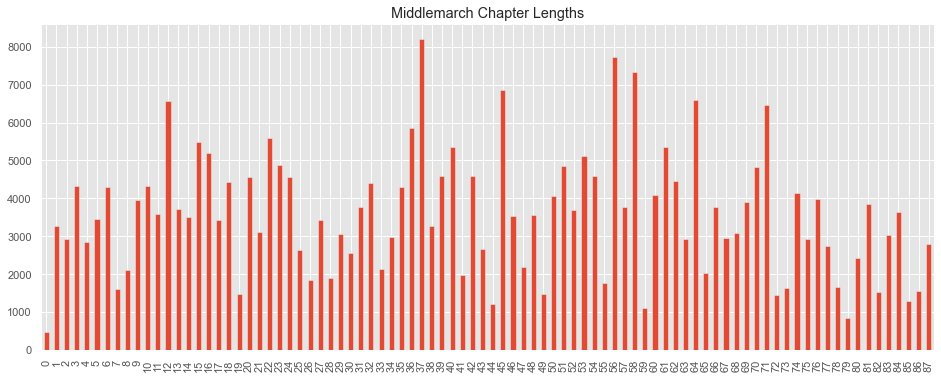

In [124]:
chapters = getChapters(mm)
chapterLengths = [len(chapter.split()) for chapter in chapters]
chapterLengthsSeries = pd.Series(chapterLengths)
chapterLengthsSeries.plot(kind='bar', title='Middlemarch Chapter Lengths')

In [125]:
def getParagraphs(text): 
    paragraphs = []
    for i, loc in enumerate(paragraphLocations): 
        if i != len(paragraphLocations)-1: 
            paragraph = mm[loc:paragraphLocations[i+1]]
            paragraphs.append(paragraph)
    return paragraph

In [126]:
paragraphs = getParagraphs(mm)
paragraphLengths = [len(paragraph.split()) for paragraph in paragraphs]
paragraphLengthsSeries = pd.Series(paragraphLengths)

In [127]:
paragraphs

'\n\nHer finely touched spirit had still its fine issues, though they were\nnot widely visible.  Her full nature, like that river of which Cyrus\nbroke the strength, spent itself in channels which had no great name on\nthe earth.  But the effect of her being on those around her was\nincalculably diffusive: for the growing good of the world is partly\ndependent on unhistoric acts; and that things are not so ill with you\nand me as they might have been, is half owing to the number who lived\nfaithfully a hidden life, and rest in unvisited tombs.\n'

## Statistics on our dataset of JSTOR matches

### Read in our ` text-matcher` JSTOR data 
Here, we're reading in the output of our text-matcher on our JSTOR data (in JSON format)

In [128]:
# Briefly commenting out the old dataset
#df = pd.read_json('../data/e3.json')
df = pd.read_json('../../../Middlematch/hyperparameter-data/t2-c3-n2-m3-no-stops.json')

In [129]:
df

,creator,datePublished,docSubType,docType,id,identifier,isPartOf,issueNumber,language,outputFormat,...,title,url,volumeNumber,wordCount,numMatches,Locations in A,Locations in B,abstract,keyphrase,subTitle
0,[Rainer Emig],2006-01-01,book-review,article,http://www.jstor.org/stable/41158244,"[{'name': 'issn', 'value': '03402827'}, {'name...",Amerikastudien / American Studies,3,[eng],"[unigram, bigram, trigram]",...,Review Article,http://www.jstor.org/stable/41158244,51,1109,1,"[[130022, 130046]]","[[6851, 6875]]",None,None,None
1,[Martin Green],1970-01-01,book-review,article,http://www.jstor.org/stable/3722819,"[{'name': 'issn', 'value': '00267937'}, {'name...",The Modern Language Review,1,[eng],"[unigram, bigram, trigram]",...,Review Article,http://www.jstor.org/stable/3722819,65,1342,0,[],[],None,None,None
2,[Richard Exner],1982-01-01,book-review,article,http://www.jstor.org/stable/40137021,"[{'name': 'issn', 'value': '01963570'}, {'name...",World Literature Today,1,[eng],"[unigram, bigram, trigram]",...,Review Article,http://www.jstor.org/stable/40137021,56,493,0,[],[],None,None,None
3,[Ruth Evelyn Henderson],1925-10-01,research-article,article,http://www.jstor.org/stable/802346,"[{'name': 'issn', 'value': '00138274'}, {'name...",The English Journal,8,[eng],"[unigram, bigram, trigram, fullText]",...,American Education Week--November 16-22; Some ...,http://www.jstor.org/stable/802346,14,2161,0,[],[],None,None,None
4,[Alan Palmer],2011-12-01,research-article,article,http://www.jstor.org/stable/10.5325/style.45.4...,"[{'name': 'issn', 'value': '00394238'}, {'name...",Style,4,[eng],"[unigram, bigram, trigram]",...,Rejoinder to Response by Marie-Laure Ryan,http://www.jstor.org/stable/10.5325/style.45.4...,45,1127,0,[],[],None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5879,[Michaela Giesenkirchen],2005-10-01,research-article,article,http://www.jstor.org/stable/27747183,"[{'name': 'issn', 'value': '15403084'}, {'name...",American Literary Realism,1,[eng],"[unigram, bigram, trigram]",...,Ethnic Types and Problems of Characterization ...,http://www.jstor.org/stable/27747183,38,7349,1,"[[23799, 24121]]","[[41472, 41793]]",None,None,None
5880,[Leon Botstein],2005-07-01,misc,article,http://www.jstor.org/stable/4123220,"[{'name': 'issn', 'value': '00274631'}, {'name...",The Musical Quarterly,2,[eng],"[unigram, bigram, trigram]",...,On the Power of Music,http://www.jstor.org/stable/4123220,88,1525,0,[],[],None,None,None
5881,[Linda M. Shires],2013-01-01,research-article,article,http://www.jstor.org/stable/24575734,"[{'name': 'issn', 'value': '10601503'}, {'name...",Victorian Literature and Culture,4,[eng],"[unigram, bigram, trigram]",...,"HARDY'S MEMORIAL ART: IMAGE AND TEXT IN ""WESSE...",http://www.jstor.org/stable/24575734,41,10736,1,"[[173657, 173756]]","[[33963, 34061]]",None,None,None
5882,[Edward H. Cohen],1990-07-01,misc,article,http://www.jstor.org/stable/3827815,"[{'name': 'issn', 'value': '00425222'}, {'name...",Victorian Studies,4,[eng],"[unigram, bigram, trigram]",...,Victorian Bibliography for 1989,http://www.jstor.org/stable/3827815,33,81819,0,[],[],None,None,None


In [170]:
df.to_csv('../data/matches.csv', encoding='utf-8')

In [130]:
# New for JSTOR 2022 data
df['year'] = pd.DatetimeIndex(df['datePublished']).year

In [131]:
# New for JSTOR 2022 data
df['year']

0       2006
1       1970
2       1982
3       1925
4       2011
        ... 
5879    2005
5880    2005
5881    2013
5882    1990
5883    1964
Name: year, Length: 5884, dtype: int64

In [132]:
df['Decade'] = df['year'] - (df['year'] % 10)
# df['Locations in A'] = df['matches'].apply(lambda x: x[1])
# df['NumMatches'] = df['matches'].apply(lambda x: x[0])

### Data Dictionary for `text matcher` dataset

Our text-matcher dataset includes the following fields:

| Data field | Definition |
| :------------- | :------------- |
| 'Locations in A' | index characters for start and end locations for quoted text in source text (A) [Middlemarch], generated by text-matcher  |
| 'Locations in B' | index characters for start and end locations for quoted text in the target text (B) [a given JSTOR text], generated by text-matcher  |
| 'author' | author name supplied by JSTOR |
| 'coverdate'|  date on cover, supplied by JSTOR |
| 'disc_name' | tags assigned to article, supplied by JSTOR |
| 'doi' |  text (DOI), supplied by JSTOR |
| 'id' |  unique identifier, supplied by JSTOR |
| 'jcode' |  shortcode for journal, supplied by JSTOR |
| 'journal' |  journal title, supplied by JSTOR |
| 'la' | language, supplied by JSTOR |
| 'no' | issue or number,  supplied by JSTOR |
| 'numMatches'| number of matches, generated by text-matcher |
| 'pages' |  page numbers, supplied by JSTOR |
| 'publisher_name' |  supplied by JSTOR |
| 'sp' |  starting page number, supplied by JSTOR |
| 'srcHtml' |  HTML version of source citation (journal, Volume, issue, date) supplied by JSTOR |
| 'title' |  title of article or piece of writing, supplied by JSTOR |
| 'topics' |  subject headings, supplied by JSTOR |
| 'ty' |  item type (fla = full length article; brv = book review; edi = opinion piece; nws OR mis) = other items, supplied by JSTOR |
| 'vo' | journal volume, supplied by JSTOR |
| 'year' |  year of publication, supplied by JSTOR |
| 'Decade' | decade, generated by Middlematch team from 'year' |
| 'Quoted Words' | total number of words in all quotations in that text, generated by generated by Middlematch team from "Locations in A' |
| 'Locations in A with Wordcounts' | list of pairs of index characters for start and end quote in the source text (A) [Middlemarch] and wordcount for each quoation, generated by generated by Middlematch team from "Locations in A' |
| 'Wordcounts' | list of wordcounts for each matched quotation, generated by text-matcher | 

In [133]:
df.columns

Index(['creator', 'datePublished', 'docSubType', 'docType', 'id', 'identifier',
       'isPartOf', 'issueNumber', 'language', 'outputFormat', 'pageCount',
       'pageEnd', 'pageStart', 'pagination', 'provider', 'publicationYear',
       'publisher', 'sourceCategory', 'tdmCategory', 'title', 'url',
       'volumeNumber', 'wordCount', 'numMatches', 'Locations in A',
       'Locations in B', 'abstract', 'keyphrase', 'subTitle', 'year',
       'Decade'],
      dtype='object')

### Functions for extracting wordcounts, numbers of quotations for diachronic and synchronic analysis

In [134]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations, useWordcounts=True, normalize=True):
    """ Turning on useWordcounts makes it so that it's weighted by wordcount. 
    Turning it off uses raw numbers of quotations. """
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts.copy()
        else: 
            decadeDict[decade] += locationsAndWordcounts.copy()
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    if useWordcounts: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  weights=[loc[1] for loc in locations],
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    else: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    if normalize: 
        decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    chunk = mm[locRange[0]:locRange[1]]
    return len(chunk.split())

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def extractWordcounts(locsAndWordcounts): 
    """ 
    Takes pairs of location ranges and wordcounts, 
    and returns just the wordcounts. 
    """
    return [item[1] for item in locsAndWordcounts 
            if len(locsAndWordcounts) > 0]

def synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    if useWordcounts: 
        binned = np.histogram(starts, bins=bins, 
                              weights=counts, range=(0, textALength))
    else: 
        binned = np.histogram(starts, bins=bins, 
                              range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df, save=False, reverse=False): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    if save: 
        plt.savefig('diachronic.png', bboxinches='tight', dpi=300, transparent=True)
    plt.show()
    
def plotSynchronicAnalysis(s, useWordcounts=True): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    if useWordcounts: 
        ax.set_ylabel('Number of Words Quoted')
    else: 
        ax.set_ylabel('Number of Quotations')
        
def plotSynchronicAnalysisHeatmap(s, useWordcounts=True): 
    vec1=synchronicAnalysis(df, useWordcounts=False)
    fig, ax = plt.subplots()
    sns.color_palette("magma")
    sns.heatmap([vec1])
    ax.set_xlabel('Chapter')
    ax.set_ylabel('Number of Quotations')
    
def plotDiachronicAnalysisBubble(df, save=False, reverse=False):
    ylabels = [str(int(decade)) for decade in df.index] + ['2020'] 
    alt.Chart(df).mark_circle().encode(
    x='Chapter',
    y='Decade',
    size='sum(count):Q'
)

### Adding additional rows to DataFrame

In [135]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [136]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

In [137]:
df['Wordcounts'] = df['Locations in A with Wordcounts'].apply(extractWordcounts)

In [138]:
# Verify that the diachronic wordcounts are the same as the synchronic wordcounts
decadeSums = diachronicAnalysis(df, decades=(1700, 2020), useWordcounts=True, normalize=False).sum(axis=1)
decadeSums.sum()

119747

In [139]:
chapterSums = synchronicAnalysis(df)
chapterSums.sum()

119892

### How many quotations do we have?

In [140]:
sum([len(item) for item in df['Locations in A'].values])

3800

#### Total number of matches

In [141]:
allMatches = []
for group in df['Locations in A'].values: 
    for pair in group: 
        allMatches.append(pair)

In [142]:
len(allMatches)

3800

### How many total articles do we have? 

In [143]:
print("Total articles with 'Middlemarch' appearing somewhere in text or metadata:")
len(df) # Total articles with "Middlemarch" mentioned somewhere

Total articles with 'Middlemarch' appearing somewhere in text or metadata:


5884

Find only those with non-trivial quotations from Middlemarch: 

In [144]:
articlesWithMatches = df[df['Locations in A'].apply(lambda x: len(x) > 0)]
articlesWithMatches.year.describe()

count    1540.000000
mean     1991.488961
std        19.713886
min      1900.000000
25%      1980.000000
50%      1994.000000
75%      2007.000000
max      2022.000000
Name: year, dtype: float64

### How many articles with matches do we have? 

In [145]:
print("Number of articles with matches to text in 'Middlemarch':")
articlesWithMatches['Locations in A'].count()

Number of articles with matches to text in 'Middlemarch':


1540

In [146]:
articlesWithMatches.Wordcounts.apply(len).head()



0      1
9      1
17    16
19     3
21     7
Name: Wordcounts, dtype: int64

In [147]:
# articlesWithMatches.to_json('../data/cleaned-matches.json')

### How many articles do we have published in each year? 
Here, we're looking just at the 489 articles with matches

In [148]:
# New for JSTOR 2022 dataset, because we have more data
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [149]:
alt.Chart(articlesWithMatches, title="Number of JSTOR articles with detected Middlemarch matches, by year").mark_bar().encode(x='year:O', y='count()').properties(width=1000)

alt.Chart(...)

### Number of non-matches in the 6,069-article dataset
One reason  the 6,069-article original dataset is so much larger has to do with the way JSTOR ingests paratextual matter from journals. We found appearance of the word "middlemarch" in paratextual matter, which was systemattically titled in JSTOR. Here we define a quick function to count the number of appearances of article-like paratextual matter: "front matter", "back matter", "table of contents" and "cover".

None of these titles are present in the smaller dataset of matches.

#### Nonmatches

In [150]:
# Try to find out what articles contain no Middlemarch citations
articlesWithoutMatches = df[df['Locations in A'].apply(lambda x: len(x) == 0)]

In [151]:
n = 10
articlesWithoutMatches['title'].value_counts()[:n].index.tolist()

['Review Article',
 'Front Matter',
 'Back Matter',
 'Volume Information',
 'Summary of Periodical Literature',
 'Index',
 'Recent Studies in the Nineteenth Century',
 'Books Received',
 'List of Publications Received',
 'INDEX']

In [152]:
# What is the most frequent name of articles with no citations?
articlesWithoutMatches['title'].describe()

count               4344
unique              2304
top       Review Article
freq                1199
Name: title, dtype: object

In [153]:
def isGarbage(itemTitle): 
    badTitles = ['front matter', 'back matter', 'table of contents', 'cover']
    if itemTitle == None: 
        return False
    for title in itemTitle: 
        for badTitle in badTitles: 
            if badTitle in title.lower(): 
                return True
    return False

In [154]:
print("Number of'front matter', 'back matter', 'table of contents', 'cover' items in the 6069-article JSTOR dataset:")
len(df[df.title.apply(isGarbage)]) # How many garbage items? 

Number of'front matter', 'back matter', 'table of contents', 'cover' items in the 6069-article JSTOR dataset:


0

### Quotation Length Statistics

In [155]:
wordcounts = []
for countSet in df['Wordcounts'].values: 
    for count in countSet: 
        wordcounts.append(count)

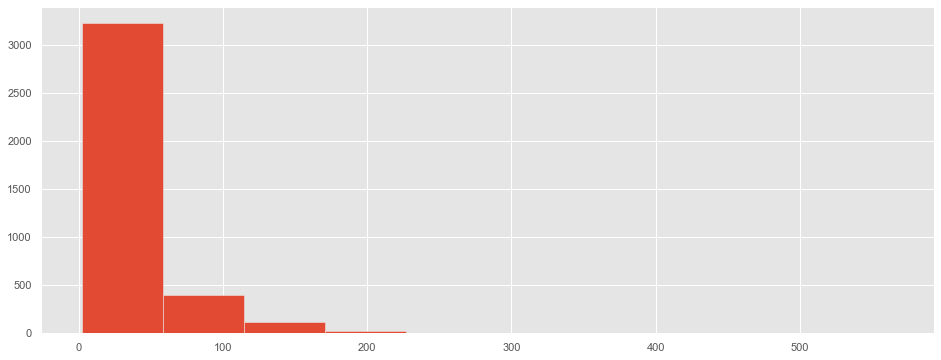

In [156]:
pd.Series(wordcounts).hist()

### Average numbers of quoted words per item

In [157]:
df['Quoted Words'].describe()

count    5884.000000
mean       20.375935
std        94.477822
min         0.000000
25%         0.000000
50%         0.000000
75%         4.000000
max      2138.000000
Name: Quoted Words, dtype: float64

In [158]:
print('Statistics on average, min, and max number of quoted words per item:')
articlesWithMatches['Quoted Words'].describe()

Statistics on average, min, and max number of quoted words per item:


count    1540.000000
mean       77.851948
std       172.172395
min         2.000000
25%         6.000000
50%        17.000000
75%        64.000000
max      2138.000000
Name: Quoted Words, dtype: float64

In [159]:
len(df[df['Quoted Words'] > 0])

1540

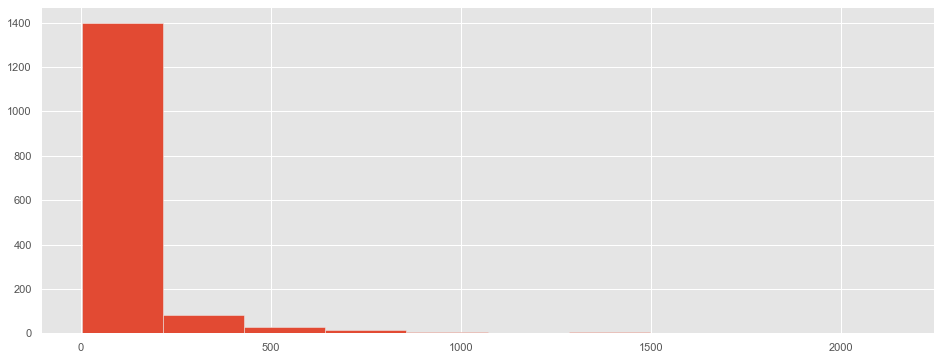

In [160]:
articlesWithMatches['Quoted Words'].hist()

### Average number of words per match, per item: 

Average number of words per match, per item: 

In [161]:
print('Average number of words per match, per item:')
articlesWithMatches['Wordcounts'].apply(np.mean).head()

Average number of words per match, per item:


0      4.000000
9     23.000000
17    21.812500
19    22.333333
21    60.000000
Name: Wordcounts, dtype: float64

In [162]:
print('Statistics on average number of words, min/max per match, per item:')
articlesWithMatches['Wordcounts'].apply(np.mean).describe()

Statistics on average number of words, min/max per match, per item:


count    1540.000000
mean       24.711784
std        29.718071
min         2.000000
25%         6.000000
50%        15.000000
75%        32.000000
max       371.250000
Name: Wordcounts, dtype: float64

# Synchronic Analysis

In these next sections, we're going to look at the "Book" and chapter level quotation counts for the entire dataset of text-matcher data.

- [Quotations and Words Quoted Per Book in Middlemarch](#Quotations-Per-Book-in-Middlemarch)
    - [Number of words quoted per book in Middlemarch, bar chart](#Number-of-words-quoted-per-book-in-Middlemarch,-bar-chart)
    - [Number of words quoted per book in Middlemarch, bubble chart](#Number-of-words-quoted-per-book-in-Middlemarch,-bubble-chart)
    - [Number of quotations per book in Middlemarch, bar chart](#Number-of-quotations-per-book-in-Middlemarch,-bar-chart)
    - [Number of quotations per book in Middlemarch, bubble chart](#Number-of-quotations-per-book-in-Middlemarch,-bubble-chart)
- [Quotes and Words Quoted by Chapter in Middlemarch](#Number-of-Quotes-(and-Words-Quoted)-by-Chapter)
	- [Number of words quoted, by chapter in Middlemarch](#Number-of-words-quoted,-by-chapter-in-Middlemarch)
	- [Number of quotations, by chapter in Middlemarch, bar chart](#Number-of-quotations,-by-chapter-in-Middlemarch,-bar-chart)
	- [Number of quotations, by chapter in Middlemarch, bubble chart](#Number-of-quotations,-by-chapter-in-Middlemarch,-bubble-chart)
	- [Normalized number of words quoted per chapter](#Normalized-number-of-words-quoted-per-chapter)
    

## Quotations Per Book in *Middlemarch*

### Number of words quoted per book in *Middlemarch*

In [163]:
wordsQuotedPerBook = synchronicAnalysis(df, bins=bookLocations, useWordcounts=True)
wordsQuotedPerBook

0        0
1    28112
2    32378
3    11351
4    10677
5     6938
6     6045
7     3882
8    20509
dtype: int64

In [164]:
wordsQuotedPerBook = pd.DataFrame(wordsQuotedPerBook, index=range(1,9), columns=['Number of Words Quoted'])
wordsQuotedPerBook['Book'] = range(1, 9)
wordsQuotedPerBook

,Number of Words Quoted,Book
1,28112,1
2,32378,2
3,11351,3
4,10677,4
5,6938,5
6,6045,6
7,3882,7
8,20509,8


### Number of words quoted per book in *Middlemarch*, bar chart

In [165]:
alt.Chart(wordsQuotedPerBook, title="Number of Words Quoted, per Book in Middlemarch").\
mark_bar().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0)), y='Number of Words Quoted:Q').\
properties(width=500)

alt.Chart(...)

### Number of words quoted per book in *Middlemarch*, bubble chart

In [166]:
# Bubble chart with horizontal labels
alt.Chart(wordsQuotedPerBook, title="Number of Words Quoted, per Book in Middlemarch").mark_circle().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0,)), 
size=alt.Size('Number of Words Quoted:Q')).properties(height=150).configure_legend(
    titleFontSize=12,
    labelFontSize=12
)

alt.Chart(...)

### Number of quotations per book in *Middlemarch*

In [167]:
quotationsPerBook = synchronicAnalysis(df, bins=bookLocations, useWordcounts=False)
quotationsPerBook

0       0
1    1036
2     880
3     334
4     311
5     251
6     224
7     142
8     622
dtype: int64

In [168]:
quotationsPerBook = pd.DataFrame(quotationsPerBook, index=range(1,9), columns=['Number of Quotations'])
quotationsPerBook['Book'] = range(1, 9)
quotationsPerBook

,Number of Quotations,Book
1,1036,1
2,880,2
3,334,3
4,311,4
5,251,5
6,224,6
7,142,7
8,622,8


### Number of quotations per book in *Middlemarch*, bar chart

In [169]:
alt.Chart(quotationsPerBook, title="Number of Quotations, per Book in Middlemarch").\
mark_bar().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0)), y='Number of Quotations:Q').\
properties(width=500)

alt.Chart(...)

### Number of quotations per book in *Middlemarch*, bubble chart

In [170]:
# Bubble chart with horizontal labels
alt.Chart(quotationsPerBook, title="Number of Quotations, per Book in Middlemarch").mark_circle().encode(x=alt.X('Book:O', axis=alt.Axis(title="Book", labelAngle=0,)), 
size=alt.Size('Number of Quotations:Q')).properties(height=150).configure_legend(
    titleFontSize=12,
    labelFontSize=12
)

alt.Chart(...)

## Number of Quotes and Words Quoted by Chapter

### Number of words quoted, by chapter in *Middlemarch*

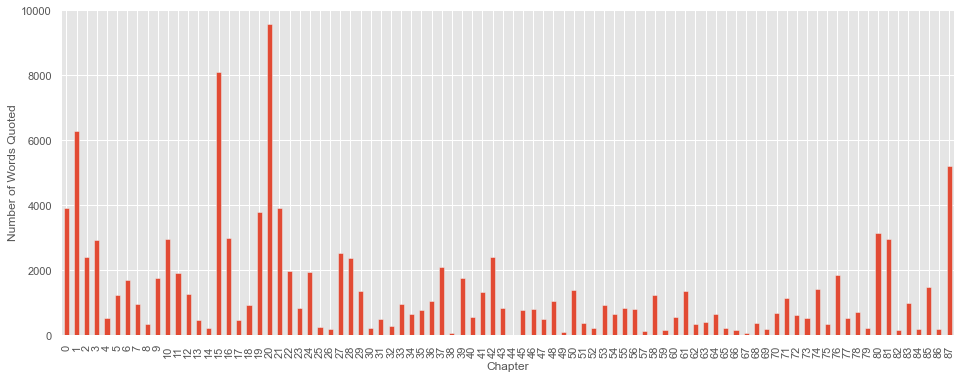

In [171]:
plotSynchronicAnalysis(synchronicAnalysis(df))

In [172]:
synchronicAnalysis(df, useWordcounts=True).to_csv('../papers/spring2017-middlemarch-paper/data/num-words-quoted-per-chapter.csv')

In [173]:
wordsQuotedPerChapter = synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True)

In [174]:
wordsQuotedPerChapter = pd.DataFrame(wordsQuotedPerChapter, index=range(0,88), columns=['Number of Words Quoted'])
wordsQuotedPerChapter['Chapter'] = range(0, 88)
wordsQuotedPerChapter

,Number of Words Quoted,Chapter
0,3919,0
1,6284,1
2,2412,2
3,2915,3
4,513,4
...,...,...
83,1000,83
84,180,84
85,1485,85
86,184,86


### Number of quotations, by chapter in *Middlemarch*, bar chart

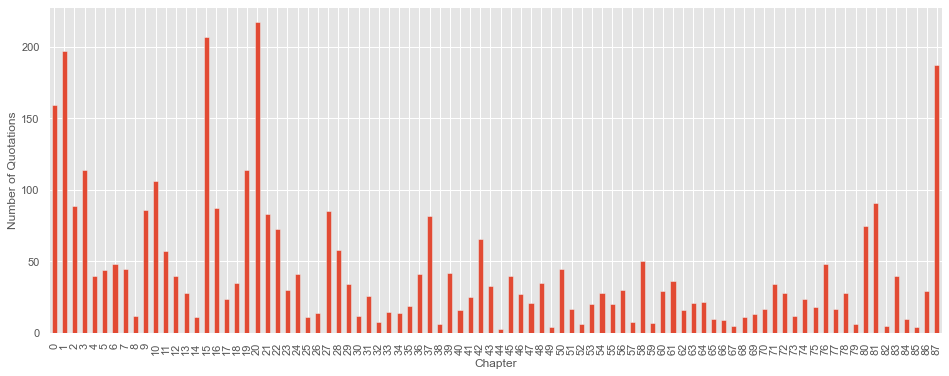

In [175]:
plotSynchronicAnalysis(synchronicAnalysis(df, useWordcounts=False), useWordcounts=False)

In [176]:
quotationsPerChapter = synchronicAnalysis(df, bins=chapterLocations, useWordcounts=False)

In [177]:
quotationsPerChapter = pd.DataFrame(quotationsPerChapter, index=range(0,88), columns=['Number of Quotations'])
quotationsPerChapter['Chapter'] = range(0, 88)
quotationsPerChapter

,Number of Quotations,Chapter
0,159,0
1,197,1
2,89,2
3,114,3
4,40,4
...,...,...
83,40,83
84,10,84
85,4,85
86,29,86


### Number of quotations, by chapter in *Middlemarch*, bar chart (sorted by frequency)

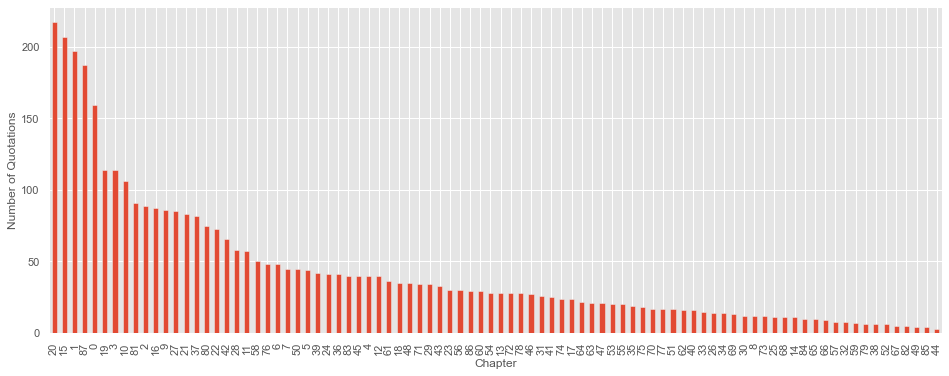

In [178]:
plotSynchronicAnalysis(quotationsPerChapter['Number of Quotations'].sort_values(ascending=False), useWordcounts=False)

In [179]:
quotationsPerParagraph = synchronicAnalysis(df, bins=paragraphLocations, useWordcounts=False)

In [180]:
quotationsPerParagraph = pd.DataFrame(quotationsPerParagraph, index=range(0,4889), columns=['Number of Quotations'])
quotationsPerParagraph['Paragraph'] = range(0, 4889)
quotationsPerParagraph

,Number of Quotations,Paragraph
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
4884,2,4884
4885,2,4885
4886,2,4886
4887,31,4887


In [181]:
# Let's remove
nonzeroquotationsPerParagraph = quotationsPerParagraph[quotationsPerParagraph['Number of Quotations'] != 0]

In [182]:
nonzeroquotationsPerParagraph.groupby('Number of Quotations').count()

,Paragraph
Number of Quotations,
1,548
2,199
3,111
4,43
5,39
6,21
7,16
8,13
9,19


### Number of quotations, by paragraph in *Middlemarch*, bar chart (sorted by frequency)

In [183]:
#ax = nonzeroquotationsPerParagraph['Number of Quotations'].sort_values(ascending=False).plot(kind='bar',\                                                                                     title="Number of Middlemarch Quotations, by Paragraph, Sorted by Frequency", figsize=(40,10))
#ax.set_xlabel('Paragraph')
#ax.set_ylabel('Number of Quotations')

### Number of Words Quoted, by chapter in *Middlemarch*, bubble chart

In [184]:
# Redo chart with horizontal labels
alt.Chart(wordsQuotedPerChapter).mark_circle().encode(x=alt.X('Chapter:Q', axis=alt.Axis(title="Chapter", tickMinStep=5,
                                       labelOverlap=False,labelAngle=0)), 
size=alt.Size('Number of Words Quoted:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=1000,height=150).configure_legend(
    titleFontSize=9,
    labelFontSize=10
)

alt.Chart(...)

### Number of quotations, by chapter in *Middlemarch*, bubble chart

In [185]:
# Redo chart with horizontal labels
alt.Chart(quotationsPerChapter).mark_circle().encode(x=alt.X('Chapter:Q', axis=alt.Axis(title="Chapter", tickMinStep=5,
                                       labelOverlap=False,labelAngle=0)), 
size=alt.Size('Number of Quotations:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=1000,height=150).configure_legend(
    titleFontSize=9,
    labelFontSize=10
)

alt.Chart(...)

In [186]:
alt.Chart(quotationsPerChapter).mark_circle().encode(y='Chapter:O', size=alt.Size('Number of Quotations:Q', scale=alt.Scale(range=[1, 1000]))).properties(width=150)

alt.Chart(...)

### Normalized number of words quoted per chapter

In [187]:
# Get the raw number of quotations per chapter
# synchronicAnalysis(df, useWordcounts=False).to_csv('../papers/spring2017-middlemarch-paper/data/num-quotations-per-chapter.csv')

Text(0, 0.5, 'Words Quoted, Normalized')

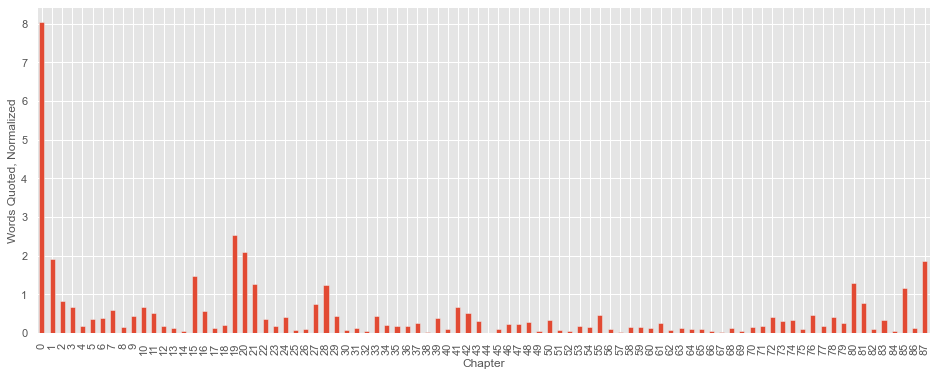

In [188]:
# Adjusted for the number of words in each chapter
ax = (synchronicAnalysis(df) / chapterLengthsSeries).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Words Quoted, Normalized')

# Diachronic Analysis

For the diachronic analysis, we examine book- and chapter-level data for quotations from *Middlemarch*. 

- [Middlemarch diachronic analysis: quotations per book, by decade](#Middlemarch-diachronic-analysis:-quotations-per-book,-by-decade)
    - [Number of quotations per book, per decade (not normalized or weighted)](#Number-of-quotations-per-book,-per-decade-(not-normalized-or-weighted))
    - [Number of quotations per book, per decade (normalized by decade)](#Number-of-quotations-per-book,-per-decade-(normalized-by-decade))
    - [Number of quotations per book, per decade (normalized by decade and weighted by word count)](#Number-of-quotations-per-book,-per-decade-(normalized-by-decade-and-weighted-by-word-count))
    - [Middlemarch quotations per book, per decade (normalized-and-weighted), heatmap](#Middlemarch-quotations-per-book,-per-decade-(normalized-and-weighted),-heat-map)
    - [Middlemarch quotations per book, per decade (normalized-and-weighted), table bubble plots](#Middlemarch-quotations-per-book,-per-decade-(normalized-and-weighted),-table-bubble-plots)
- [ Middlemarch diachronic analysis: quotations per chapter,by decade](#Middlemarch-diachronic-analysis:-quotations-per-chapter,-by-decade)
    - [Number of quotations per chapter, per decade (not normalized or weighted)](#Number-of-quotations-per-chapter,-per-decade-(not-normalized-or-weighted))
    - [Number of quotations per chapter, per decade (normalized by decade and weighted by word count)](#Number-of-quotations-per-chapter,-per-decade-(normalized-by-decade-and-weighted-by-word-count))
    - [Middlemarch quotations per chapter, per decade (normalized and weighted), heat map](#Middlemarch-quotations-per-chapter,-per-decade-(normalized-and-weighted),-heat-map)
    - [Middlemarch quotations per chapter, per decade (normalized and weighted), table bubble plots](#Middlemarch-quotations-per-chapter,-per-decade-(normalized-and-weighted),-table-bubble-plots)

## *Middlemarch* diachronic analysis: quotations per book, by decade

We use three different methods to analyze quotations per book, by decade. First, we examine the raw counts of quotations per book, per decade. Because our corpus contains [varying numbers of JSTOR texsts per decade](#How-many-articles-do-we-have-published-in-each-year?), we've decided to also weigh by length of quotation and normalize per decade.

### Number of quotations per book, per decade (not normalized or weighted)

In [189]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
booksNotNormalizedNotWeightedDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations,\
                                                        useWordcounts=False, normalize=False).sort_index()
print('Number of quotations per book, per decade')
booksNotNormalizedNotWeightedDiaDF

Number of quotations per book, per decade


,0,1,2,3,4,5,6,7,8
1960,0,55,49,17,23,23,9,12,54
1970,0,151,97,40,36,33,28,14,69
1980,0,183,145,50,47,29,44,22,117
1990,0,234,214,69,85,65,39,30,134
2000,0,196,170,60,58,47,50,23,80
2010,0,177,163,86,54,40,46,33,111


In [190]:
booksNotNormalizedNotWeightedDiaDF['decade'] = booksNotNormalizedNotWeightedDiaDF.index

In [191]:
booksNotNormalizedNotWeightedDiaDFMelted = booksNotNormalizedNotWeightedDiaDF.melt(id_vars='decade', var_name='book')

In [192]:
# cut out erroneous "book 0" material (ie title page)
booksNotNormalizedNotWeightedDiaDFMelted = booksNotNormalizedNotWeightedDiaDFMelted[booksNotNormalizedNotWeightedDiaDFMelted.book != 0]

In [193]:
booksNotNormalizedNotWeightedDiaDFMeltedExport = booksNotNormalizedNotWeightedDiaDFMelted.rename(columns={"value": "Number of Quotations"})
# To export a CSV, uncomment the line below
# booksNotNormalizedNotWeightedDiaDFMeltedExport.to_csv("Middlemarch-quotations-per-book-per-decade-not-weighted-or-normalized.csv")

In [194]:
alt.Chart(booksNotNormalizedNotWeightedDiaDFMelted,\
          title="Middlemarch quotations per book, per decade (not weighted or normalized)")\
.mark_rect().encode(x='book:O', y='decade:O', color=alt.Color('value', legend=alt.Legend(title="Number of Quotations"))).properties(width=500, height=300)

alt.Chart(...)

### Number of quotations per book, per decade (normalized by decade)

In [195]:
# Number of quotations (not weighted), normalized by decade(counts are scaled to the maximum value per decade)
booksNotWeightedDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations, useWordcounts=False, normalize=True).sort_index()
print('Quotations per book, per decade (normalized by decade):')
booksNotWeightedDiaDF

Quotations per book, per decade (normalized by decade):


,0,1,2,3,4,5,6,7,8
1960,0.0,1.0,0.890909,0.309091,0.418182,0.418182,0.163636,0.218182,0.981818
1970,0.0,1.0,0.642384,0.264901,0.238411,0.218543,0.185430,0.092715,0.456954
1980,0.0,1.0,0.792350,0.273224,0.256831,0.158470,0.240437,0.120219,0.639344
1990,0.0,1.0,0.914530,0.294872,0.363248,0.277778,0.166667,0.128205,0.572650
2000,0.0,1.0,0.867347,0.306122,0.295918,0.239796,0.255102,0.117347,0.408163
2010,0.0,1.0,0.920904,0.485876,0.305085,0.225989,0.259887,0.186441,0.627119


### Number of quotations per book, per decade (normalized by decade and weighted by word count)

In [196]:
# Weighted by wordcount (by the number of words in the quotation) and normalized by decade(counts are scaled to the maximum value per decade)
booksDiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=bookLocations, useWordcounts=True, normalize=True).sort_index()
print('Quotations per book, per decade (weighted by length of quotation and normalized by decade):')
booksDiaDF

Quotations per book, per decade (weighted by length of quotation and normalized by decade):


,0,1,2,3,4,5,6,7,8
1960,0.0,0.567051,1.000000,0.229606,0.354556,0.481098,0.068046,0.166335,0.467967
1970,0.0,1.000000,0.839023,0.271083,0.264752,0.206195,0.148994,0.121411,0.555505
1980,0.0,0.877438,0.946007,0.268733,0.287826,0.156231,0.250462,0.099569,1.000000
1990,0.0,0.816222,1.000000,0.208229,0.418430,0.176811,0.106744,0.078743,0.528329
2000,0.0,1.000000,0.964953,0.528371,0.265020,0.223465,0.289386,0.079940,0.463117
2010,0.0,0.748342,1.000000,0.519065,0.374503,0.152023,0.190650,0.188992,0.539954


In [197]:
booksDiaDF['decade'] = booksDiaDF.index

In [198]:
booksMelted = booksDiaDF.melt(id_vars='decade', var_name='book')

In [199]:
# cut out erroneous "book 0" material (ie title page)
booksMelted = booksMelted[booksMelted.book != 0]

### *Middlemarch* quotations per book, per decade (normalized and weighted), heat map

In [200]:
alt.Chart(booksMelted,\
          title="Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_rect().encode(x='book:O', y='decade:O', color=alt.Color('value', legend=alt.Legend(title="Number of Quotations (normalized)"))).properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

### Middlemarch quotations per book, per decade (normalized and weighted), table bubble plots

In [201]:
alt.Chart(booksMelted, title="Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_circle().encode(
    x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
    y='decade:O',\
                          size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)")))\
.properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10)

alt.Chart(...)

In [202]:
#Change scale of the circle markers to a threshold scale (and resize to make the steps in the scale more visible)
alt.Chart(booksMelted, title="Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_circle().encode(
    x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

## *Middlemarch* diachronic analysis: quotations per chapter, by decade

### Number of quotations per chapter, per decade (not normalized or weighted)

In [203]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
diaDFquoteOnly = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations, useWordcounts=False, normalize=False).sort_index()
diaDFquoteOnly.columns.name ='chapter'
diaDFquoteOnly.index.name = 'decade'

In [204]:
with pd.option_context("display.min_rows", 6, "display.max_rows", 100, \
                       "display.max_columns", 90, 'display.max_colwidth', 150):
    display(diaDFquoteOnly)

chapter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
decade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,8,7,5,4,2,3,0,6,1,6,8,3,2,0,0,8,3,3,0,1,20,11,3,2,1,1,1,7,3,0,1,1,0,0,0,5,2,4,0,2,3,6,1,2,0,0,7,3,1,0,4,1,2,3,1,0,3,0,1,0,3,1,0,1,2,0,2,0,1,0,0,6,0,1,0,4,6,2,6,1,4,12,1,2,0,0,6,9
1970,20,26,20,24,8,4,11,8,5,8,7,8,2,2,1,21,14,1,3,9,27,8,11,0,3,1,3,14,12,3,1,3,0,0,1,0,2,11,1,4,2,3,12,9,1,4,6,1,5,0,4,1,1,1,4,2,5,2,8,1,3,2,1,1,3,1,0,0,2,3,1,3,3,2,7,1,4,1,1,1,10,9,0,4,1,0,3,22
1980,34,41,13,21,4,10,4,8,0,13,17,9,9,9,4,38,17,2,6,18,37,9,5,11,2,0,2,8,7,12,3,4,1,0,6,1,4,20,0,9,0,0,7,7,0,2,1,10,1,0,3,5,0,0,10,4,4,0,11,2,2,6,5,1,9,4,2,1,0,2,0,3,9,2,3,2,15,6,4,0,17,13,1,7,0,4,3,31
1990,38,38,20,23,5,14,13,10,1,14,24,21,14,9,4,66,11,10,11,34,41,15,12,1,6,4,6,27,5,8,1,6,1,4,5,7,18,16,1,7,0,10,21,2,1,19,8,5,11,0,14,1,2,2,2,4,3,1,10,3,4,7,5,6,3,5,1,2,3,0,6,4,6,1,4,3,10,2,13,2,17,20,2,15,3,0,3,33
2000,28,30,19,23,12,8,7,8,2,26,22,7,4,4,1,27,26,2,4,26,45,12,23,9,7,3,2,7,4,5,5,4,4,10,0,3,4,18,2,8,6,2,15,6,1,9,1,1,9,3,10,1,1,5,10,4,7,5,4,1,8,8,3,5,0,0,2,0,3,7,3,3,5,1,0,4,9,2,4,2,6,5,0,5,2,0,6,29
2010,21,53,12,13,9,5,10,4,2,17,17,7,7,2,1,32,15,4,10,24,39,21,15,7,20,2,0,20,22,5,1,7,2,0,2,2,10,10,1,12,5,4,8,6,0,4,2,0,8,0,5,8,0,7,1,6,7,0,15,0,7,8,2,7,5,0,1,2,2,1,4,11,4,3,7,3,3,4,0,0,15,11,1,7,0,0,2,51


In [205]:
diaDFquoteOnly['decade'] = diaDFquoteOnly.index

In [206]:
diaDFquoteOnlyMelted = diaDFquoteOnly.melt(id_vars='decade')

In [207]:
#Chart with raw quotations
alt.Chart(diaDFquoteOnlyMelted, title="Middlemarch quotations per chapter, per decade (not weighted or normalized)")\
.mark_rect().encode(x='chapter:O', y='decade:O', 
                    color=alt.Color('value', legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

In [208]:
alt.Chart(diaDFquoteOnlyMelted, title="Middlemarch quotations per chapter, per decade (not weighted or normalized)").mark_circle().encode(x='chapter:O', 
                                                     y=alt.Y('decade:O'), size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

### Number of quotations per chapter, per decade (normalized by decade and weighted by word count)

In [209]:
# Weighted by wordcount (by the number of words in the quoatation) and normalized by decade(counts are scaled to the maximum value per decade)
diaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations, useWordcounts=True, normalize=True).sort_index()
diaDF.columns.name = 'chapter'
diaDF.index.name = 'decade'

In [210]:
with pd.option_context("display.min_rows", 6, "display.max_rows", 100, \
                       "display.max_columns", 90, 'display.max_colwidth', 150):
    display(diaDF)

chapter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
decade,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,0.119514,0.119514,0.266106,0.068161,0.012138,0.022409,0.000000,0.104575,0.008403,0.267974,0.230626,0.036415,0.074697,0.000000,0.000000,0.621849,0.272642,0.020542,0.000000,0.005602,1.000000,0.372549,0.053221,0.019608,0.013072,0.005602,0.004669,0.183940,0.298786,0.000000,0.006536,0.006536,0.000000,0.000000,0.000000,0.106443,0.048553,0.156863,0.000000,0.030812,0.045752,0.320261,0.123249,0.024276,0.000000,0.000000,0.326797,0.047619,0.026144,0.000000,0.228758,0.007470,0.053221,0.414566,0.002801,0.000000,0.102708,0.000000,0.015873,0.000000,0.014006,0.024276,0.000000,0.020542,0.022409,0.000000,0.074697,0.000000,0.007470,0.000000,0.000000,0.265173,0.000000,0.004669,0.000000,0.014939,0.130719,0.017740,0.161531,0.039216,0.183007,0.225957,0.003735,0.065359,0.000000,0.0,0.022409,0.228758
1970,0.224055,0.575258,0.584192,0.393814,0.107904,0.061856,0.360825,0.115464,0.158076,0.087973,0.079725,0.226804,0.063918,0.004124,0.002749,0.627491,0.340893,0.004811,0.012371,0.219244,1.000000,0.134021,0.204811,0.000000,0.061168,0.002062,0.009622,0.381443,0.229553,0.094845,0.003436,0.041924,0.000000,0.000000,0.032990,0.000000,0.062543,0.188316,0.007560,0.058419,0.018557,0.107216,0.329210,0.197938,0.004124,0.031615,0.074914,0.013058,0.151890,0.000000,0.071478,0.004124,0.018557,0.059107,0.087285,0.065979,0.103093,0.012371,0.121649,0.003436,0.009622,0.046048,0.003436,0.017869,0.226804,0.004811,0.000000,0.000000,0.070790,0.021306,0.009622,0.017869,0.051546,0.023368,0.523024,0.002749,0.131959,0.035052,0.010309,0.013058,0.327148,0.111340,0.000000,0.037113,0.004811,0.0,0.008247,0.408935
1980,0.437037,0.772391,0.164310,0.377778,0.032997,0.249832,0.106397,0.175758,0.000000,0.105051,0.212121,0.160269,0.084175,0.092256,0.061953,0.801347,0.377104,0.035690,0.099663,0.400673,0.918519,0.242424,0.073401,0.235690,0.010774,0.000000,0.006061,0.151515,0.084848,0.296970,0.047138,0.022222,0.026263,0.000000,0.064646,0.041751,0.042424,0.253872,0.000000,0.415488,0.000000,0.000000,0.125926,0.127273,0.000000,0.008081,0.004040,0.191919,0.006061,0.000000,0.098990,0.076094,0.000000,0.000000,0.151515,0.152189,0.019529,0.000000,0.204040,0.028283,0.032323,0.191919,0.041751,0.012795,0.129293,0.055219,0.006734,0.003367,0.000000,0.030976,0.000000,0.088215,0.144108,0.245791,0.058586,0.024242,0.292929,0.103704,0.064646,0.000000,0.360269,0.303030,0.010101,0.085522,0.000000,1.0,0.015488,0.571717
1990,0.514066,0.436061,0.150043,0.271952,0.046462,0.135550,0.196505,0.068201,0.013640,0.075021,0.249361,0.264706,0.227195,0.072890,0.033674,1.000000,0.237425,0.109122,0.113811,0.511509,0.777494,0.290708,0.093777,0.008525,0.073316,0.028986,0.060102,0.259165,0.084825,0.064791,0.001705,0.034527,0.002131,0.057118,0.193095,0.201194,0.185848,0.176897,0.003410,0.078005,0.000000,0.162830,0.355499,0.014493,0.002131,0.151321,0.026002,0.057545,0.164535,0.000000,0.121910,0.016198,0.004689,0.014493,0.017903,0.034101,0.018329,0.001705,0.082268,0.038363,0.027280,0.092498,0.033674,0.020034,0.005968,0.057971,0.002558,0.004689,0.029838,0.000000,0.069480,0.064791,0.065217,0.022592,0.060529,0.054135,0.110401,0.048167,0.126598,0.043905,0.298380,0.255754,0.022592,0.217818,0.013214,0.0,0.009804,0.364024
2000,0.452062,0.739689,0.176754,0.371184,0.052491,0.179968,0.151044,0.069095,0.009641,0.302625,0.400107,0.269416,0.035351,0.028923,0.006427,0.470809,0.305838,0.020889,0.101768,0.539904,1.000000,0.146224,0.476165,0.212641,0.217461,0.061061,0.006963,0.111944,0.252276,0.194965,0.062132,0.055169,0.089984,0.431173,0.000000,0.027317,0.023032,0.258168,0.018211,0.103910,0.088913,0.044992,0.286020,0.084092,0.002142,0.121585,0.008570,0.002142,0.167649,0.045528,0.118372,0.003749,0.

In [211]:
diaDF['decade'] = diaDF.index

In [212]:
diaMelted = diaDF.melt(id_vars='decade')

### *Middlemarch* quotations per chapter, per decade (normalized and weighted), heat map

In [213]:
alt.Chart(diaMelted, title="Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)")\
.mark_rect().encode(x='chapter:O', y='decade:O', 
                                        color=alt.Color('value', legend=alt.Legend(title="Number of Quotations (normalized)")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

### *Middlemarch* quotations per chapter, per decade (normalized and weighted), table bubble plots

In [214]:
alt.Chart(diaMelted, title="Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)").mark_circle().encode(x='chapter:O', y='decade:O', size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

In [215]:
#Redo Chart to rotate tick marks
alt.Chart(diaMelted, title="Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)").mark_circle().encode(
    x=alt.X('chapter:Q', axis=alt.Axis(tickMinStep=5,
                                       labelOverlap=False,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

alt.Chart(...)

In [216]:
# Get the normalized proportion of, say, Chapter 20 in 1950: 
diachronicAnalysis(df)[20][1950]

0.6318681318681318

# *Middlemarch* chapter-specific analysis

- [Chapter 15](#Chapter-15)
    - [Paragraph-level-analysis of Chapter 15](#Paragraph-level-analysis-of-Chapter-15)
- [Chapter 20](#Chapter-20)
    - [Paragraph-level-analysis of Chapter 20](#Paragraph-level-analysis-of-Chapter-20)
    - [#Which paragraphs in Chapter 20 are quoted most often?](#Which-paragraphs-in-Chapter-20-are-quoted-most-often?)

## Chapter 15

In [217]:
# Try to find out why Ch. 15 was so big in the 80s and 90s. 
chap15s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: # Looking at the 1980s, 1990s
        for start in starts: 
            if start > 290371 and start < 322052: # Does it cite Chapter XV? 
                if row.id not in ids: 
                    chap15s.append(row)
                    ids.append(row.id)

In [218]:
# Get the titles of those articles.
print('Titles of articles that quote Chapter 15:')
[item.title for item in chap15s]

Titles of articles that quote Chapter 15:


['Woman of Maxims:',
 'Brava! And Farewell to Greatheart',
 'The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript',
 '"Middlemarch" and George Eliot\'s Female (Re) Vision of Shakespeare',
 'Heroism and Organicism in the Case of Lydgate',
 'Professional Judgment and the Rationing of Medical Care',
 'SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"',
 'Reflections on "The Philosophical Bases of Feminist Literary Criticisms"',
 'Strategies for Writing: Theories and Practices',
 'Review Article',
 'AN END TO CONVERTING PATIENTS\' STOMACHS INTO DRUG-SHOPS: LYDGATE\'S NEW METHOD OF CHARGING HIS PATIENTS IN "MIDDLEMARCH"',
 'Review Article',
 'Illuminating the Vision of Ordinary Life: A Tribute to "Middlemarch"',
 'Review Article',
 "PLEXUSES AND GANGLIA: ELIOTS AND LEWES'S THEORY OF NERVE-CONSCIOUSNESS",
 'Review Article',
 'Middlemarch, Realism and the Birth of the Clinic',
 'ERZÄHLERISCHE OBJEKTIVITÄT, ,AUTHORIAL INTRUSIONS‘ UND ENGLISCHER REALISMUS',
 'Review Article',
 '

In [219]:
xvStart, xvEnd = chapterLocations[15:17]

In [220]:
print(mm[xvStart:xvStart+1000]) 

CHAPTER XV.

    "Black eyes you have left, you say,
     Blue eyes fail to draw you;
     Yet you seem more rapt to-day,
     Than of old we saw you.

    "Oh, I track the fairest fair
     Through new haunts of pleasure;
     Footprints here and echoes there
     Guide me to my treasure:

    "Lo! she turns--immortal youth
     Wrought to mortal stature,
     Fresh as starlight's aged truth--
     Many-named Nature!"


A great historian, as he insisted on calling himself, who had the
happiness to be dead a hundred and twenty years ago, and so to take his
place among the colossi whose huge legs our living pettiness is
observed to walk under, glories in his copious remarks and digressions
as the least imitable part of his work, and especially in those initial
chapters to the successive books of his history, where he seems to
bring his armchair to the proscenium and chat with us in all the lusty
ease of his fine English.  But Fielding lived when the days were longer
(for time, like mone

### Paragraph-level analysis of Chapter 15

In [221]:
# Try to find out which articles cite the first 2/3 of Chapter XV (with Lydgate's scientific research) 
# vs the last 1/3 on the story of Laure
chap15p1s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 313892: # Does it cite the first 2/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15p1s.append(row)
                    ids.append(row.id)
chap15p2s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 313892 and start < 322052: # Does it cite the last 1/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15p2s.append(row)
                    ids.append(row.id)                   
                    

In [222]:
# Get the titles of articles citing the first 2/3 
print('Titles of articles that quote the first 2/3 of Chapter 15:')
[item.title for item in chap15p1s]

Titles of articles that quote the first 2/3 of Chapter 15:


['Woman of Maxims:',
 'Brava! And Farewell to Greatheart',
 'The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript',
 'Heroism and Organicism in the Case of Lydgate',
 'Professional Judgment and the Rationing of Medical Care',
 'SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"',
 'Reflections on "The Philosophical Bases of Feminist Literary Criticisms"',
 'Strategies for Writing: Theories and Practices',
 'Review Article',
 'AN END TO CONVERTING PATIENTS\' STOMACHS INTO DRUG-SHOPS: LYDGATE\'S NEW METHOD OF CHARGING HIS PATIENTS IN "MIDDLEMARCH"',
 'Review Article',
 'Illuminating the Vision of Ordinary Life: A Tribute to "Middlemarch"',
 'Review Article',
 "PLEXUSES AND GANGLIA: ELIOTS AND LEWES'S THEORY OF NERVE-CONSCIOUSNESS",
 'Review Article',
 'Middlemarch, Realism and the Birth of the Clinic',
 'ERZÄHLERISCHE OBJEKTIVITÄT, ,AUTHORIAL INTRUSIONS‘ UND ENGLISCHER REALISMUS',
 'Review Article',
 'The Aesthetics of Sympathy:',
 'NARRATIVE VOICE AND THE "FEMININE" NOVEL

In [223]:
# Get the titles of those articles.
print('Titles of articles that quote the last 1/3 of Chapter 15:')
[item.title for item in chap15p2s]

Titles of articles that quote the last 1/3 of Chapter 15:


['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript',
 '"Middlemarch" and George Eliot\'s Female (Re) Vision of Shakespeare',
 'Microscopy and Semiotic in Middlemarch',
 "George Eliot's Reflexive Text: Three Tonalities in the Narrative Voice of Middlemarch",
 'Re-Reading Character',
 'The Strange Case of Monomania: Patriarchy in Literature, Murder in Middlemarch, Drowning in Daniel Deronda']

In [224]:
# Verify that we have the right location for the start of Laure's story in the last 1/3 of Chapter XV
print(mm[313892:313892+1500]) 



As to women, he had once already been drawn headlong by impetuous
folly, which he meant to be final, since marriage at some distant
period would of course not be impetuous.  For those who want to be
acquainted with Lydgate it will be good to know what was that case of
impetuous folly, for it may stand as an example of the fitful swerving
of passion to which he was prone, together with the chivalrous kindness
which helped to make him morally lovable.  The story can be told
without many words.  It happened when he was studying in Paris, and
just at the time when, over and above his other work, he was occupied
with some galvanic experiments.  One evening, tired with his
experimenting, and not being able to elicit the facts he needed, he
left his frogs and rabbits to some repose under their trying and
mysterious dispensation of unexplained shocks, and went to finish his
evening at the theatre of the Porte Saint Martin, where there was a
melodrama which he had already seen several times; 

In [225]:
# Verify the location of the eipgraph and first paragraph
print(mm[290371:290371+1571]) 

CHAPTER XV.

    "Black eyes you have left, you say,
     Blue eyes fail to draw you;
     Yet you seem more rapt to-day,
     Than of old we saw you.

    "Oh, I track the fairest fair
     Through new haunts of pleasure;
     Footprints here and echoes there
     Guide me to my treasure:

    "Lo! she turns--immortal youth
     Wrought to mortal stature,
     Fresh as starlight's aged truth--
     Many-named Nature!"


A great historian, as he insisted on calling himself, who had the
happiness to be dead a hundred and twenty years ago, and so to take his
place among the colossi whose huge legs our living pettiness is
observed to walk under, glories in his copious remarks and digressions
as the least imitable part of his work, and especially in those initial
chapters to the successive books of his history, where he seems to
bring his armchair to the proscenium and chat with us in all the lusty
ease of his fine English.  But Fielding lived when the days were longer
(for time, like mone

In [226]:
chap15para1s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 290371 and start < 291943: # Does it cite the last 1/3 of Chapter XV? 
                if row.id not in ids: 
                    chap15para1s.append(row)
                    ids.append(row.id)    

In [227]:
# Get the titles of articles that cite paragraph 1 of Chapter 15
print('Titles of articles that quote paragraph 1 of Chapter 15:')
[item.title for item in chap15para1s]

Titles of articles that quote paragraph 1 of Chapter 15:


['Woman of Maxims:',
 'Brava! And Farewell to Greatheart',
 'The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript',
 'Strategies for Writing: Theories and Practices',
 'Illuminating the Vision of Ordinary Life: A Tribute to "Middlemarch"',
 'Middlemarch, Realism and the Birth of the Clinic',
 'NARRATIVE VOICE AND THE "FEMININE" NOVELIST: DINAH MULOCK AND GEORGE ELIOT',
 'Review Article',
 'Microscopy and Semiotic in Middlemarch',
 "George Eliot's Reflexive Text: Three Tonalities in the Narrative Voice of Middlemarch",
 'George Eliot and the Eighteenth-Century Novel',
 'Versions of Narrative: Overt and Covert Narrators in Nineteenth Century Historiography',
 'George Eliot\'s Scrupulous Research: The Facts behind Eliot\'s Use of the "Keepsake in Middlemarch"',
 'Eliot and Woolf as Historians of the Common Life',
 "George Eliot's Hypothesis of Reality",
 'MIXED AND ERRING HUMANITY: GEORGE ELIOT, G. H. LEWES AND GOETHE',
 'Dangerous Crossings: Dickens, Digression, and Mo

In [228]:
chap15Lydgates = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1980, 1990]: 
        for start in starts: 
            if start > 291942 and start < 313892: # Does it cite the first 2/3 of Chapter XV?
                if row.id not in ids: 
                    chap15Lydgates.append(row)
                    ids.append(row.id)
                    
# Get the titles of articles that cite Lydgate section
print('Titles of scholarly writings that quote the first 2/3 of Chapter 15:')
[item.title for item in chap15Lydgates]

Titles of scholarly writings that quote the first 2/3 of Chapter 15:


['The Union of "Miss Brooke" and "Middlemarch": A Study of the Manuscript',
 'Heroism and Organicism in the Case of Lydgate',
 'Professional Judgment and the Rationing of Medical Care',
 'SILENCE, GESTURE, AND MEANING IN "MIDDLEMARCH"',
 'Reflections on "The Philosophical Bases of Feminist Literary Criticisms"',
 'Review Article',
 'AN END TO CONVERTING PATIENTS\' STOMACHS INTO DRUG-SHOPS: LYDGATE\'S NEW METHOD OF CHARGING HIS PATIENTS IN "MIDDLEMARCH"',
 'Review Article',
 'Review Article',
 "PLEXUSES AND GANGLIA: ELIOTS AND LEWES'S THEORY OF NERVE-CONSCIOUSNESS",
 'Review Article',
 'Middlemarch, Realism and the Birth of the Clinic',
 'ERZÄHLERISCHE OBJEKTIVITÄT, ,AUTHORIAL INTRUSIONS‘ UND ENGLISCHER REALISMUS',
 'Review Article',
 'The Aesthetics of Sympathy:',
 'Lamarque and Olsen on Literature and Truth',
 'Microscopy and Semiotic in Middlemarch',
 'Review Article',
 'LYDGATE\'S RESEARCH PROJECT IN "MIDDLEMARCH"',
 'Eliot and Woolf as Historians of the Common Life',
 'The Language

## Chapter 20

In [229]:
# Try to find out what articles cited chapter 20 
chap20s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 406324 and start < 432778: # Does it cite Chapter XX? 
                if row.id not in ids: 
                    chap20s.append(row)
                    ids.append(row.id)


In [230]:
# Get the titles of those articles.
print('Titles of scholarly writings that quote Chapter 20:')
[item.title for item in chap20s]

Titles of scholarly writings that quote Chapter 20:


['“I Mistook the Faint Shadow”',
 'Review Article',
 'Reader Response',
 'Torpedoes, tapirs and tortoises: scientific discourse in "Middlemarch"',
 'Sympathy Time: Adam Smith, George Eliot, and the Realist Novel',
 'Review Article',
 '"Middlemarch," Obligation, and Dorothea\'s Duplicity',
 '“A True Prophet”? Speculation in Victorian Sensory Physiology and George Eliot’s “The Lifted Veil”',
 '"MIDDLEMARCH": GLOSS ON A "ROMAN A CLEF"',
 'One-Way Communication',
 'Review Article',
 'Love, Age, and Loyalty in Alice Munro’s “The Bear Came over the Mountain” and Sarah Polley’s Away from Her',
 'A Note on Middlemarch',
 "ELIOT'S SPANISH CONNECTION: CASAUBON, THE AVATAR OF QUIXOTE",
 'The Greeks, the Germans, and George Eliot',
 "Ian McEwan's Saturday and the Aesthetics of Prose",
 'Review Article',
 'Responsibility without Consciousness',
 'Proserpine and Pessimism: Goddesses of Death, Life, and Language from Swinburne to Wharton',
 'Rights, Communities, and Tradition',
 'Dorothea\'s Boudoir:

In [231]:
# Number of articles that cite Chapter 20
len(chap20s)

147

In [232]:
xxStart, xxEnd = chapterLocations[20:22] # Chapter 20 Boundaries

In [233]:
print(mm[xxStart:xxStart+1000]) # Verify we have Ch. 20

CHAPTER XX.

    "A child forsaken, waking suddenly,
     Whose gaze afeard on all things round doth rove,
     And seeth only that it cannot see
     The meeting eyes of love."


Two hours later, Dorothea was seated in an inner room or boudoir of a
handsome apartment in the Via Sistina.

I am sorry to add that she was sobbing bitterly, with such abandonment
to this relief of an oppressed heart as a woman habitually controlled
by pride on her own account and thoughtfulness for others will
sometimes allow herself when she feels securely alone.  And Mr.
Casaubon was certain to remain away for some time at the Vatican.

Yet Dorothea had no distinctly shapen grievance that she could state
even to herself; and in the midst of her confused thought and passion,
the mental act that was struggling forth into clearness was a
self-accusing cry that her feeling of desolation was the fault of her
own spiritual poverty.  She had married the man of her choice, and with
the advantage over most girls t

In [234]:
xx = mm[xxStart:xxEnd]

In [235]:
xxParaLocations = [match.start() for match in re.finditer('\n\n+', mm)]
xxParaLocations = [x for x in xxParaLocations if (x > xxStart) and (x < xxEnd)] 

In [236]:
mm[xxParaLocations[4]:xxParaLocations[5]]

'\n\nBut this stupendous fragmentariness heightened the dreamlike\nstrangeness of her bridal life.  Dorothea had now been five weeks in\nRome, and in the kindly mornings when autumn and winter seemed to go\nhand in hand like a happy aged couple one of whom would presently\nsurvive in chiller loneliness, she had driven about at first with Mr.\nCasaubon, but of late chiefly with Tantripp and their experienced\ncourier.  She had been led through the best galleries, had been taken\nto the chief points of view, had been shown the grandest ruins and the\nmost glorious churches, and she had ended by oftenest choosing to drive\nout to the Campagna where she could feel alone with the earth and sky,\naway-from the oppressive masquerade of ages, in which her own life too\nseemed to become a masque with enigmatical costumes.'

In [237]:
articlesWithMatches['Locations in A'].loc[0]

[[130022, 130046]]

In [238]:
def inXX(matches): 
    """ Determine if the article has a match in Ch. 20"""
    for match in matches: 
        if match[0] > xxStart and match[0] < xxEnd:
            return True
    return False

In [239]:
articlesWithMatches['Locations in A'].apply(inXX).head()

0     False
9     False
17    False
19    False
21    False
Name: Locations in A, dtype: bool

### Paragraph-level analysis of Chapter 20

In [240]:
# Try to find out what articles cite paragraph 6 in Chapter 20
chap20par6s = []
ids = []
for i, row in df.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 411152 and start < 412177: # Does it cite Chapter XX, paragraph 6? 
                if row.id not in ids: 
                    chap20par6s.append(row)
                    ids.append(row.id)


In [241]:
# Get the titles of those articles.
print('Titles of scholarly writings that quote paragraph 6 of Chapter 20:')
[item.title for item in chap20par6s]

Titles of scholarly writings that quote paragraph 6 of Chapter 20:


['“I Mistook the Faint Shadow”',
 'Torpedoes, tapirs and tortoises: scientific discourse in "Middlemarch"',
 'Sympathy Time: Adam Smith, George Eliot, and the Realist Novel',
 '“A True Prophet”? Speculation in Victorian Sensory Physiology and George Eliot’s “The Lifted Veil”',
 'One-Way Communication',
 'Review Article',
 'A Note on Middlemarch',
 "Ian McEwan's Saturday and the Aesthetics of Prose",
 'Responsibility without Consciousness',
 'Proserpine and Pessimism: Goddesses of Death, Life, and Language from Swinburne to Wharton',
 'Rights, Communities, and Tradition',
 'Reading, Writing, and Eavesdropping: Some Thoughts on the Nature of Realistic Fiction',
 'The Sound and the Fury: A Logic of Tragedy',
 'Views from above and below: George Eliot and Fakir Mohan Senapati',
 'Review Article',
 'The Not-Quite Said',
 'Review Article',
 'Incarnation and Inwardness:',
 '"Be Ye Lukewarm!": The Nineteenth-Century Novel and Social Action',
 'Development and the Learning Organisation: An Intr

In [242]:
len(chap20par6s) # The number of items citing paragraph 6 in chapter 20

66

In [243]:
def paraIndicesIn20(matches, paraLocations=xxParaLocations): 
    """ Determine paragraph number (index) for match in Ch. 20. """
    paraIndices = []
    if inXX(matches): 
        paraBoundaries = list(zip(paraLocations, paraLocations[1:]))
        for match in matches: 
            for i, paraBoundary in enumerate(paraBoundaries): 
                if set(range(match[0], match[1])) & set(range(paraBoundary[0], paraBoundary[1])): # find the set intersection of the ranges of pairs
                    paraIndices.append(i)
                else: 
                    paraIndices.append(None)
    return paraIndices
                    
                

In [244]:
len(set(range(8, 10)) & set(range(1, 9)))

1

In [245]:
articlesWithMatches['paraIndicesIn20'] = articlesWithMatches['Locations in A'].apply(paraIndicesIn20)

<ipython-input-245-88f15cdc3712>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articlesWithMatches['paraIndicesIn20'] = articlesWithMatches['Locations in A'].apply(paraIndicesIn20)


In [246]:
counters = list(articlesWithMatches['paraIndicesIn20'].apply(Counter))

In [247]:
grandTally = Counter()

In [248]:
for counter in counters: 
    grandTally += counter

In [249]:
del grandTally[None]

In [250]:
dict(grandTally)

{6: 69,
 5: 47,
 3: 7,
 15: 4,
 10: 20,
 29: 2,
 25: 3,
 4: 6,
 7: 9,
 12: 3,
 14: 3,
 33: 6,
 18: 3,
 26: 8,
 17: 7,
 16: 7,
 11: 8,
 22: 1,
 1: 1,
 2: 1,
 13: 1,
 8: 1,
 9: 2}

### Which paragraphs in Chapter 20 are quoted most often?

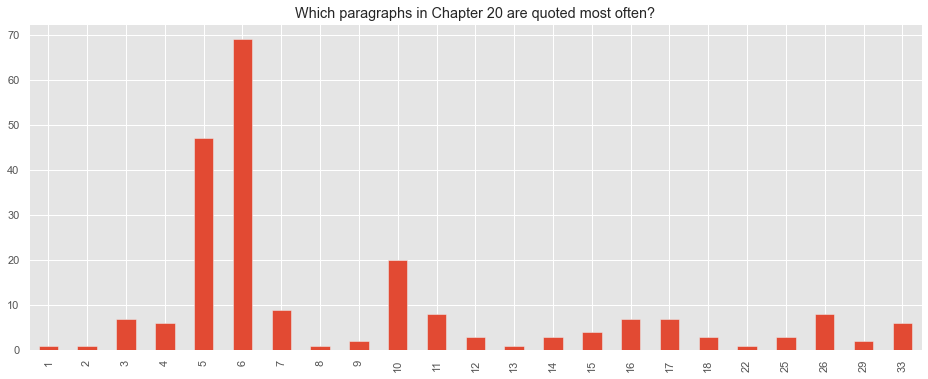

In [251]:
pd.Series(dict(grandTally)).sort_index().plot(kind='bar', title="Which paragraphs in Chapter 20 are quoted most often?")

In [252]:
print(mm[xxParaLocations[5]:xxParaLocations[7]]) # What are paragraphs #5 and #6? 



To those who have looked at Rome with the quickening power of a
knowledge which breathes a growing soul into all historic shapes, and
traces out the suppressed transitions which unite all contrasts, Rome
may still be the spiritual centre and interpreter of the world.  But
let them conceive one more historical contrast: the gigantic broken
revelations of that Imperial and Papal city thrust abruptly on the
notions of a girl who had been brought up in English and Swiss
Puritanism, fed on meagre Protestant histories and on art chiefly of
the hand-screen sort; a girl whose ardent nature turned all her small
allowance of knowledge into principles, fusing her actions into their
mould, and whose quick emotions gave the most abstract things the
quality of a pleasure or a pain; a girl who had lately become a wife,
and from the enthusiastic acceptance of untried duty found herself
plunged in tumultuous preoccupation with her personal lot.  The weight
of unintelligible Rome might lie easily on b

# *Middlemarch* Quotations, by Journal

- [Descriptive-statistics-on-journals-in-JSTOR-dataset](#Descriptive-statistics-on-journals-in-JSTOR-dataset)
- [GE-GHLS, NLH, and ELH)](#GE-GHLS,-NLH,-and-ELH)
    - [#George-Eliot---George-Henry-Lewes-Studies-(GE-GHLS)](#George-Eliot---George-Henry-Lewes-Studies-(GE-GHLS))
    - [#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-title-is-"George-Eliot---George-Henry-Lewes-Studies"](#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-title-is-"George-Eliot---George-Henry-Lewes-Studies")
    - [#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-code-is-"georelioghlstud"](#George-Eliot---George-Henry-Lewes-Studies-articles-where-journal-code-is-"georelioghlstud")
    - [#Compare-the-specialist-journal,-George-Eliot---George-Henry-Lewes-Studies,-with-all-other-journals](#Compare-the-specialist-journal,-George-Eliot---George-Henry-Lewes-Studies,-with-all-other-journals)
- [NLH](#NLH)
    - [#NLH-articles-where-journal-title-is-"New-Literary-History"](#NLH-articles-where-journal-title-is-"New-Literary-History")
    - [NLH-articles-where-journal-code-is-"newlitehist"](#NLH-articles-where-journal-code-is-"newlitehist")
-[ELH](#ELH)
    - [#ELH-articles-where-journal-title-is-"ELH"](#ELH-articles-where-journal-title-is-"ELH")
    - [#ELH-articles-where-journal-code-is-"elh"](#ELH-articles-where-journal-code-is-"elh")

## Descriptive statistics on journals in JSTOR dataset

In [253]:
# Top 10 journals with most articles in our dataset
# OLD
df['journal'] = df['isPartOf']
journalStats = df['journal'].value_counts()
print("Journal   |    Number of articles in our dataset")
journalStats[:10]

Journal   |    Number of articles in our dataset


Victorian Studies                            459
George Eliot - George Henry Lewes Studies    231
The Modern Language Review                   192
Nineteenth-Century Fiction                   192
The Review of English Studies                190
PMLA                                         154
NOVEL: A Forum on Fiction                    148
Nineteenth-Century Literature                139
Studies in the Novel                         124
ELH                                          102
Name: journal, dtype: int64

In [254]:
journalList = journalStats.index

In [255]:
journals = pd.DataFrame({title: synchronicAnalysis(df.loc[df['journal'] == title]) for title in journalList }).T

In [256]:
cutoff = 1500
topJournals = journals.loc[journals.sum(axis=1) > cutoff]
otherJournals = journals.loc[journals.sum(axis=1) < cutoff]
topJournals.loc['Other'] = otherJournals.sum()

/Users/sceckert/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


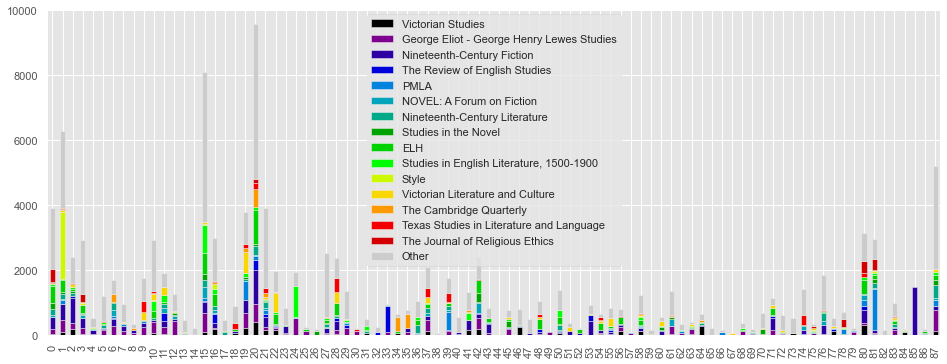

In [257]:
topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')

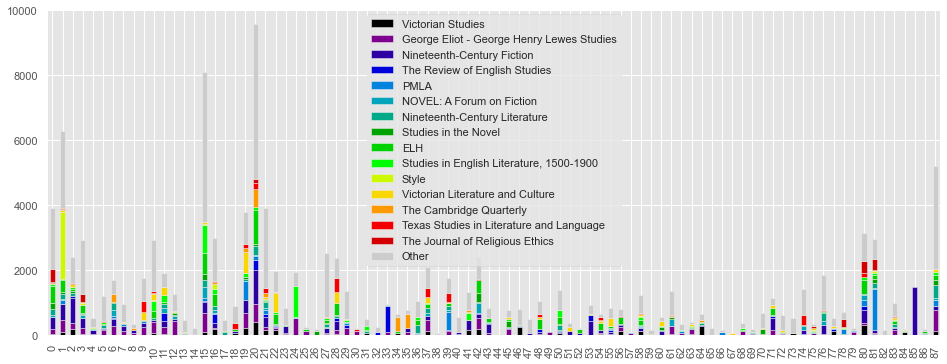

In [258]:
ax = topJournals.T.plot(kind='bar', stacked=True, colormap='nipy_spectral')
fig = ax.get_figure()
fig.savefig('synchronic-journals.png', bboxinches='tight', dpi=300)

In [151]:
# Print the total number of journals
len(journalStats)

789

In [152]:
list_of_VS_journals = ['Victorian Studies', 'George Eliot - George Henry Lewes Studies','Nineteenth-Century Fiction', 'Nineteenth-Century Literature', 'Dickens Studies Annual', 'Victorian Literature and Culture', 'Victorian Review', 'The George Eliot, George Henry Lewes Newsletter','Victorian Periodicals Review', 'Dickens Quarterly', 'Victorian Poetry', 'The Thomas Hardy Journal', 'The Gaskell Society Journal', 'The Gaskell Journal', 'Newsletter of the Victorian Studies Association of Western Canada', 'Dickens Studies Newsletter', 'Browning Institute Studies', 'Victorian Periodicals Newsletter', 'Carlyle Studies Annual', 'The Hardy Society Journal', 'The Hardy Review', 'Studies in Browning and His Circle', 'The Wilkie Collins Journal', 'The Wildean', 'Carlyle Newsletter', 'Carlyle Annual', '19th-Century Music', 'Dickens Studies']

In [153]:
len(list_of_VS_journals)

28

In [156]:
just_VS_journals_quotes = articlesWithMatches[articlesWithMatches['isPartOf'].isin(list_of_VS_journals)]

In [157]:
just_VS_journals_quotes['isPartOf'].value_counts()

George Eliot - George Henry Lewes Studies                            106
Victorian Studies                                                     78
Nineteenth-Century Fiction                                            68
Victorian Literature and Culture                                      37
Nineteenth-Century Literature                                         37
Dickens Studies Annual                                                19
Victorian Review                                                      13
Victorian Poetry                                                      12
The George Eliot, George Henry Lewes Newsletter                       11
Victorian Periodicals Review                                           8
The Thomas Hardy Journal                                               5
Dickens Quarterly                                                      5
Browning Institute Studies                                             4
The Gaskell Society Journal                        

In [165]:
articlesWithMatches['isPartOf'].value_counts()

George Eliot - George Henry Lewes Studies        106
Victorian Studies                                 78
Nineteenth-Century Fiction                        68
PMLA                                              47
ELH                                               42
                                                ... 
Legacy                                             1
Notes                                              1
Nineteenth-Century French Studies                  1
QED: A Journal in GLBTQ Worldmaking                1
The Basic Writings of Josiah Royce, Volume II      1
Name: isPartOf, Length: 403, dtype: int64

In [158]:
just_VS_journals_quotes['numMatches'].sum()

1248

In [162]:
articlesWithMatches['numMatches'].sum()

3800

In [163]:
# What proportion of matches come from Victorian studies journals?
just_VS_journals_quotes['numMatches'].sum() / articlesWithMatches['numMatches'].sum()

0.32842105263157895

# *GE-GHLS*, *NLH*, and *ELH* 

## *George Eliot - George Henry Lewes Studies* (*GE-GHLS*)

### George Eliot - George Henry Lewes Studies articles where journal title is "George Eliot - George Henry Lewes Studies"

In [260]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']

In [261]:
pd.set_option('display.max_columns', 207)

In [262]:
geJournals 

,creator,datePublished,docSubType,docType,id,identifier,isPartOf,issueNumber,language,outputFormat,pageCount,pageEnd,pageStart,pagination,provider,publicationYear,publisher,sourceCategory,tdmCategory,title,url,volumeNumber,wordCount,numMatches,Locations in A,Locations in B,abstract,keyphrase,subTitle,year,Decade,Quoted Words,Locations in A with Wordcounts,Wordcounts,journal
37,[ELIZABETH WINSTON],1995-09-01,book-review,article,http://www.jstor.org/stable/43595523,"[{'name': 'issn', 'value': '23721901'}, {'name...",George Eliot - George Henry Lewes Studies,28/29,[eng],"[unigram, bigram, trigram]",6.0,106,101,pp. 101-106,jstor,1995,Penn State University Press,"[Language & Literature, Humanities]",[Arts - Literature],Review Article,http://www.jstor.org/stable/43595523,None,1981,0,[],[],None,None,None,1995,1990,0,[],[],George Eliot - George Henry Lewes Studies
76,[Katherine Newey],2011-09-01,research-article,article,http://www.jstor.org/stable/42827892,"[{'name': 'issn', 'value': '23721901'}, {'name...",George Eliot - George Henry Lewes Studies,60/61,[eng],"[unigram, bigram, trigram]",16.0,141,126,pp. 126-141,jstor,2011,Penn State University Press,"[Language & Literature, Humanities]",[Arts - Literature],"The ""British Matron"" and the Poetic Drama: The...",http://www.jstor.org/stable/42827892,None,7038,1,"[[502448, 502471]]","[[18540, 18563]]",None,None,None,2011,2010,4,"[([502448, 502471], 4)]",[4],George Eliot - George Henry Lewes Studies
101,None,2015-11-01,other,article,http://www.jstor.org/stable/10.5325/georeliogh...,"[{'name': 'issn', 'value': '23721901'}, {'name...",George Eliot - George Henry Lewes Studies,2,[eng],"[unigram, bigram, trigram]",2.0,ii,i,pp. i-ii,jstor,2015,Penn State University Press,"[Language & Literature, Humanities]",None,Front Matter,http://www.jstor.org/stable/10.5325/georeliogh...,67,438,0,[],[],None,None,None,2015,2010,0,[],[],George Eliot - George Henry Lewes Studies
107,[AVROM FLEISHMAN],2008-09-01,research-article,article,http://www.jstor.org/stable/42827960,"[{'name': 'issn', 'value': '23721901'}, {'name...",George Eliot - George Henry Lewes Studies,54/55,[eng],"[unigram, bigram, trigram]",79.0,76,1,pp. 1-76,jstor,2008,Penn State University Press,"[Language & Literature, Humanities]",[Arts - Performing arts],GEORGE ELIOT'S READING: A CHRONOLOGICAL LIST,http://www.jstor.org/stable/42827960,None,22729,1,"[[1138948, 1138968]]","[[73073, 73093]]",None,None,None,2008,2000,4,"[([1138948, 1138968], 4)]",[4],George Eliot - George Henry Lewes Studies
108,[Judith Adler],2018-10-01,research-article,article,http://www.jstor.org/stable/10.5325/georeliogh...,"[{'name': 'issn', 'value': '23721901'}, {'name...",George Eliot - George Henry Lewes Studies,2,[eng],"[unigram, bigram, trigram]",29.0,171,143,pp. 143-171,jstor,2018,Penn State University Press,"[Language & Literature, Humanities]",[Arts - Literature],Hidden Allusion in the Finale of <em>Middlemar...,http://www.jstor.org/stable/10.5325/georeliogh...,70,9258,1,"[[1792915, 1793447]]","[[350, 876]]",This article argues that the famous concluding...,None,None,2018,2010,97,"[([1792915, 1793447], 97)]",[97],George Eliot - George Henry Lewes Studies
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5798,[TERENCE R. WRIGHT],1995-09-01,book-review,article,http://www.jstor.org/stable/43595524,"[{'name': 'issn', 'value': '23721901'}, {'name...",George Eliot - George Henry Lewes Studies,28/29,[eng],"[unigram, bigram, trigram]",3.0,109,107,pp. 107-109,jstor,1995,Penn State University Press,"[Language & Literature, Humanities]",None,Review Article,http://www.jstor.org/stable/43595524,None,862,0,[],[],None,None,None,1995,1990,0,[],[],George Eliot - George Henry Lewes Studies
5835,[SALEEL NURBHAI],1997-09-01,research-article,article,http://www.jstor.org/stable/42827636,"[{'name': 'issn', 'value': '23721901'}, {'name...",George Eliot - George Henry Lewes Studies,32/33,[eng],"[u

In [263]:
print(geJournals.title)

37                                         Review Article
76      The "British Matron" and the Poetic Drama: The...
101                                          Front Matter
107          GEORGE ELIOT'S READING: A CHRONOLOGICAL LIST
108     Hidden Allusion in the Finale of <em>Middlemar...
                              ...                        
5798                                       Review Article
5835                JEWISH MYTH IN GEORGE ELIOT'S FICTION
5853    GEORGE ELIOT AND GEORGE HENRY LEWES: SELECTED ...
5865                                          Back Matter
5876                                  A GEORGE ELIOT NOTE
Name: title, Length: 231, dtype: object


In [264]:
print("Number of George ELiot - George Henry Lewes Studies articles where journal title is 'George ELiot - George Henry Lewes Studies':")
len(geJournals)

Number of George ELiot - George Henry Lewes Studies articles where journal title is 'George ELiot - George Henry Lewes Studies':


231

### George Eliot - George Henry Lewes Studies articles where journal code is "georelioghlstud"

In [265]:
print("Number of George Eliot - George Henry Lewes Studies articles where journal code is 'georelioghlstud':")
geJournalCodes = df.loc[df['jcode'].str[0] == 'georelioghlstud']
len(geJournalCodes)

Number of George Eliot - George Henry Lewes Studies articles where journal code is 'georelioghlstud':


KeyError: 'jcode'

In [ ]:
geJournalCodes

### Diachronic Analysis of *GE-GHLS* Quotations

In [ ]:
# Weighted by wordcount (by the number of words in the quotation) and normalized by decade(counts are scaled to the maximum value per decade)
GEGHLSbooksDiaDF = diachronicAnalysis(geJournals, decades=(1990, 2020), bins=bookLocations, useWordcounts=True, normalize=True).sort_index()
print('GE-GHLS Quotations per book, per decade (weighted by length of quotation and normalized by decade):')
GEGHLSbooksDiaDF

In [ ]:
GEGHLSbooksDiaDF['decade'] = GEGHLSbooksDiaDF.index

In [ ]:
GEGHLSbooksMelted = GEGHLSbooksDiaDF.melt(id_vars='decade', var_name='book')

In [ ]:
# cut out erroneous "book 0" material (ie title page)
GEGHLSbooksMelted = GEGHLSbooksMelted[GEGHLSbooksMelted.book != 0]

### *GE-GHLS* : Middlemarch quotations per book, per decade (normalized and weighted), table bubble plots

In [ ]:
#Change scale of the circle markers to a threshold scale (and resize to make the steps in the scale more visible)
alt.Chart(GEGHLSbooksMelted, title="GE-GHLS Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_circle().encode(
    x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

In [ ]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
GEGHLSbooksNotNormalizedNotWeightedDiaDF = diachronicAnalysis(geJournals, decades=(1960, 2020), bins=bookLocations,\
                                                        useWordcounts=False, normalize=False).sort_index()
print('Number of quotations per book, per decade in GE-GHLS')
GEGHLSbooksNotNormalizedNotWeightedDiaDF

In [ ]:
GEGHLSbooksNotNormalizedNotWeightedDiaDF['decade'] = GEGHLSbooksNotNormalizedNotWeightedDiaDF.index

In [ ]:
GEGHLSbooksNotNormalizedNotWeightedDiaDFMelted = GEGHLSbooksNotNormalizedNotWeightedDiaDF.melt(id_vars='decade', var_name='book')

In [ ]:
# cut out erroneous "book 0" material (ie title page)
GEGHLSbooksNotNormalizedNotWeightedDiaDFMelted = GEGHLSbooksNotNormalizedNotWeightedDiaDFMelted[GEGHLSbooksNotNormalizedNotWeightedDiaDFMelted.book != 0]

### *GE-GHLS* : Middlemarch quotations per book, per decade (not normalized or weighted), table bubble plots

In [ ]:
alt.Chart(GEGHLSbooksNotNormalizedNotWeightedDiaDFMelted, title="GE-GHLS Middlemarch quotations per book, per decade (not weighted or normalized by decade)").mark_circle().encode(
        x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
                                                     y=alt.Y('decade:O'), size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

### *GE-GHLS*: Number of quotations per chapter, per decade (not normalized or weighted)

In [ ]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
GEGHLSdiaDFquoteOnly = diachronicAnalysis(geJournals, decades=(1960, 2020), bins=chapterLocations, useWordcounts=False, normalize=False).sort_index()
GEGHLSdiaDFquoteOnly.columns.name ='chapter'
GEGHLSdiaDFquoteOnly.index.name = 'decade'

In [ ]:
GEGHLSdiaDFquoteOnly

In [ ]:
GEGHLSdiaDFquoteOnly['decade'] = GEGHLSdiaDFquoteOnly.index

In [ ]:
GEGHLSdiaDFquoteOnlyMelted = GEGHLSdiaDFquoteOnly.melt(id_vars='decade')

In [ ]:
alt.Chart(GEGHLSdiaDFquoteOnlyMelted, title="GE-GHLS Middlemarch quotations per chapter, per decade (not weighted or normalized)").mark_circle().encode(x='chapter:O', 
                                                     y=alt.Y('decade:O'), size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

### *GE-GHLS*: Number of quotations per chapter, per decade (normalized by decade and weighted by word count)

In [ ]:
# Weighted by wordcount (by the number of words in the quoatation) and normalized by decade(counts are scaled to the maximum value per decade)
GEGHLSnormalizeddiaDF = diachronicAnalysis(geJournals, decades=(1960, 2020), bins=chapterLocations, useWordcounts=True, normalize=True).sort_index()
GEGHLSnormalizeddiaDF.columns.name = 'chapter'
GEGHLSnormalizeddiaDF.index.name = 'decade'

In [ ]:
GEGHLSnormalizeddiaDF

In [ ]:
GEGHLSnormalizeddiaDF['decade'] = GEGHLSnormalizeddiaDF.index

In [ ]:
GEGHLSnormalizeddiaMelted = GEGHLSnormalizeddiaDF.melt(id_vars='decade')

### *GE-GHLS*: *Middlemarch* quotations per chapter, per decade (normalized and weighted), table bubble plots

In [ ]:
#Redo Chart to rotate tick marks
alt.Chart(GEGHLSnormalizeddiaMelted, title="GE-GHLS Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)").mark_circle().encode(
    x=alt.X('chapter:Q', axis=alt.Axis(tickMinStep=5,
                                       labelOverlap=False,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

### Compare the specialist journal, *George Eliot - George Henry Lewes Studies*, with all other journals

In [ ]:
geJournals = df.loc[df['journal'] == 'George Eliot - George Henry Lewes Studies']
otherJournals = df.loc[df['journal'] != 'George Eliot - George Henry Lewes Studies']

In [ ]:
# Normalize
geDF = synchronicAnalysis(geJournals)
otherDF = synchronicAnalysis(otherJournals)
normGE = geDF.div(geDF.max())
normOther = otherDF.div(otherDF.max())

In [ ]:
fig = plt.figure()
ax = (normGE - normOther).plot(kind='bar')
fig.add_subplot(ax)
ax.set_xlabel('Chapter')
ax.set_ylabel('Specialization Index')
# Save a big version for publication. 
fig.savefig('specialization.png', bboxinches='tight', dpi=300)

## *NLH*

### NLH articles where journal title is "New Literary History"

In [ ]:
nlhJournals = df.loc[df['journal'] == 'New Literary History']

In [ ]:
pd.set_option('display.max_rows', 300)

In [ ]:
nlhJournals 

In [ ]:
print("Number of NLH articles where journal title is 'New Literary History':")
len(nlhJournals)

### NLH articles where journal code is "newlitehist"

In [ ]:
print('NLH articles where journal code is "newlitehist":')
nlhJournalCodes = df.loc[df['jcode'].str[0] == 'newlitehist']
len(nlhJournalCodes)

## *ELH*

### ELH articles where journal title is "ELH"

In [ ]:
elhJournals = df.loc[df['journal'] == 'ELH']
elhJournals

In [ ]:
len(elhJournals)

### ELH articles where journal code is "elh"

In [ ]:
elhJournalCodes = df.loc[df['jcode'].str[0] == 'elh']
len(elhJournalCodes)

### Diachronic Analysis of *ELH* Quotations

In [ ]:
# Weighted by wordcount (by the number of words in the quotation) and normalized by decade(counts are scaled to the maximum value per decade)
ELHbooksDiaDF = diachronicAnalysis(elhJournalCodes, decades=(1960, 2020), bins=bookLocations, useWordcounts=True, normalize=True).sort_index()
print('GE-GHLS Quotations per book, per decade (weighted by length of quotation and normalized by decade):')
ELHbooksDiaDF

In [ ]:
ELHbooksDiaDF['decade'] = ELHbooksDiaDF.index

In [ ]:
ELHbooksMelted = ELHbooksDiaDF.melt(id_vars='decade', var_name='book')

In [ ]:
# cut out erroneous "book 0" material (ie title page)
ELHbooksMelted = ELHbooksMelted[ELHbooksMelted.book != 0]

### *ELH* : Middlemarch quotations per book, per decade (normalized and weighted), table bubble plots

In [ ]:
#Change scale of the circle markers to a threshold scale (and resize to make the steps in the scale more visible)
alt.Chart(ELHbooksMelted, title="ELH Middlemarch quotations per book, per decade (weighted by length of quotation and normalized by decade)")\
.mark_circle().encode(
    x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=500, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

In [ ]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
ELHbooksNotNormalizedNotWeightedDiaDF = diachronicAnalysis(elhJournalCodes, decades=(1960, 2020), bins=bookLocations,\
                                                        useWordcounts=False, normalize=False).sort_index()
print('Number of quotations per book, per decade in GE-GHLS')
ELHbooksNotNormalizedNotWeightedDiaDF

In [ ]:
ELHbooksNotNormalizedNotWeightedDiaDF['decade'] = ELHbooksNotNormalizedNotWeightedDiaDF.index

In [ ]:
ELHbooksNotNormalizedNotWeightedDiaDFMelted = ELHbooksNotNormalizedNotWeightedDiaDF.melt(id_vars='decade', var_name='book')

In [ ]:
# cut out erroneous "book 0" material (ie title page)
ELHbooksNotNormalizedNotWeightedDiaDFMelted = ELHbooksNotNormalizedNotWeightedDiaDFMelted[ELHbooksNotNormalizedNotWeightedDiaDFMelted.book != 0]

### *ELH* : Middlemarch quotations per book, per decade (not normalized or weighted), table bubble plots

In [ ]:
alt.Chart(ELHbooksNotNormalizedNotWeightedDiaDFMelted, title="ELH Middlemarch quotations per book, per decade (not weighted or normalized by decade)").mark_circle().encode(
        x=alt.X('book:O', axis=alt.Axis(labelOverlap=True,
                                   labelAngle=0)), 
                                                     y=alt.Y('decade:O'), size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

###  *ELH*: Number of quotations per chapter, per decade (not normalized or weighted)

In [ ]:
# Raw quotation counts (not weighted by the number of words in the quoatation or normalized by decade)
# Turning on useWordcounts makes it so that it's weighted by wordcount. Turning it off uses raw numbers of quotations.
ELHdiaDFquoteOnly = diachronicAnalysis(elhJournalCodes, decades=(1960, 2020), bins=chapterLocations, useWordcounts=False, normalize=False).sort_index()
ELHdiaDFquoteOnly.columns.name ='chapter'
ELHdiaDFquoteOnly.index.name = 'decade'

In [ ]:
ELHdiaDFquoteOnly

In [ ]:
ELHdiaDFquoteOnly['decade'] = ELHdiaDFquoteOnly.index

In [ ]:
ELHdiaDFquoteOnlyMelted = ELHdiaDFquoteOnly.melt(id_vars='decade')

In [ ]:
alt.Chart(ELHdiaDFquoteOnlyMelted, title="ELH Middlemarch quotations per chapter, per decade (not weighted or normalized)").mark_circle().encode(x='chapter:O', 
                                                     y=alt.Y('decade:O'), size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations")))\
.properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

### *ELH*: Number of quotations per chapter, per decade (normalized by decade and weighted by word count)

In [ ]:
# Weighted by wordcount (by the number of words in the quoatation) and normalized by decade(counts are scaled to the maximum value per decade)
ELHnormalizeddiaDF = diachronicAnalysis(df, decades=(1960, 2020), bins=chapterLocations, useWordcounts=True, normalize=True).sort_index()
ELHnormalizeddiaDF.columns.name = 'chapter'
ELHnormalizeddiaDF.index.name = 'decade'

In [ ]:
ELHnormalizeddiaDF

In [ ]:
ELHnormalizeddiaDF['decade'] = ELHnormalizeddiaDF.index

In [ ]:
ELHnormalizeddiaMelted = diaDF.melt(id_vars='decade')

### ELH *Middlemarch* quotations per chapter, per decade (normalized and weighted), table bubble plots

In [ ]:
#Redo Chart to rotate tick marks
alt.Chart(ELHnormalizeddiaMelted, title="ELH Middlemarch quotations per chapter, per decade (normalized by decade and weighted by word count)").mark_circle().encode(
    x=alt.X('chapter:Q', axis=alt.Axis(tickMinStep=5,
                                       labelOverlap=False,
                                   labelAngle=0)), 
    y=alt.Y('decade:O'), 
    size=alt.Size('value',  legend=alt.Legend(title="Number of Quotations (normalized)"), 
                  scale=alt.Scale(type = 'threshold', domain = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], range =[0, 20, 60, 100, 150, 250, 350, 500, 750, 1000, 1500, 2000,]))).properties(width=1000, height=300).configure_legend(
titleFontSize=10,
labelFontSize=10
) 

## *Victorian Studies*

### Articles where journal title is "Victorian Studies"

In [ ]:
vsJournals = df.loc[df['journal'] == 'Victorian Studies']

In [ ]:
pd.set_option('display.max_rows', 300)

In [ ]:
vsJournals 

In [ ]:
print("Number of  articles where journal title is 'Victorian Studies':")
len(vsJournals)

### articles where journal code is "victorianstudies"

In [ ]:
print('Articles where journal code is "victorianstudies":')
vsJournalCodes = df.loc[df['jcode'].str[0] == 'victorianstudies']
len(vsJournalCodes)

### Victorian Studies Chapter 15

In [ ]:
# Try to find out why Ch. 15 was so big in the 80s and 90s. 
chap15sVS = []
idsVS = []

for i, row in vsJournals.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1960, 1970, 1980, 1990, 2000, 2010, 2020]: # Looking at the 1980s, 1990s
        for start in starts: 
            if start > 290371 and start < 322052: # Does it cite Chapter XV? 
                if row.id not in ids: 
                    chap15sVS.append(row)
                    idsVS.append(row.id)

In [ ]:
print('Titles of articles that quote Chapter 15:')
[item.title for item in chap15sVS]

In [ ]:
print('Ids of articles that quote Chapter 15:')
chap15sVS_ids = [item.id for item in chap15sVS]
chap15sVS_ids

In [ ]:
locs_in_A_df = pd.DataFrame(list(zip(idsVS, chap15sVS, starts_in_A_VS)), columns = ['id', 'Chap', 'Locations in B'])

In [ ]:
df_filtered = df[df['id'].isin(chap15sVS_ids)]
df_filtered

In [ ]:
df_filtered.to_csv('../../../Middlematch/victorian_studies_chap_15.csv', encoding='utf-8')

# Evaluation

## Generating samples of dataset for evaluating the precision and recall of text matcher
First, we're going to generate a smaller sample dataset, which we'll then perform bootstrapping on.

First, let's stratify our dataset by year, and then take a random sample in that year.

In [ ]:
articlesWithMatches1960_2015 = articlesWithMatches[articlesWithMatches['Decade'] >= 1960]
len(articlesWithMatches1960_2015)

In [ ]:
len(articlesWithMatches1960_2015['year'].value_counts())

### Generate random sample

In [ ]:
sampleData = articlesWithMatches1960_2015.sample(n=56, random_state=56)
sampleData['journal'].value_counts(sort=False)

In [ ]:
sampleData.to_csv('../data/sample_dataset.csv', encoding='utf-8')

In [ ]:
# Function to loop over each row, extracting locations in A and metadata, then output that to a new text file
def extractSampleDataMatches(sampleData):
    for i, row in sampleData.iterrows():
        title = row['title']
        year = row['year']
        # Print a break between each article
        with open('../data/sample-data-matches.txt', "a") as f:
            print("---------------------------------------\n", file=f)
            print(title, file=f)
            print(year, file=f)
        # For each pair of locations in the "Locations in A" column, iterate over, printing the location indexes
        # Followed by the text of the match
            for pair in row['Locations in A']:
                print(f"Location in A: {pair}", file=f)
                print(mm[pair[0]:pair[1]]+"\n", file=f)
    
extractSampleDataMatches(sampleData)

### Evaluation metrics

Terminology
TP (True Positives):
TN (True Negatives): 
FP (False Posiives): 
FN (False Negatives): 

**Classification accuracy:** percentage of correctly identified quotes and non-quotes, or overall, how often is the matcher correct? classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)))

 **Recall (or "sensitivity")**: When the actual match is correc, how often is the prediction correct? recall = TP / float(FN + TP)


**Precision:** When a match is detected, how often is that match correct? precision = TP / float(TP + FP)


In [ ]:
chapterLocations[42:44] 

In [ ]:
chapterLocations[15:17] 

In [ ]:
# Try to find out what articles cite Ch 42
chap42 = []
ids = []
for i, row in elhJournalCodes.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 889546 and start < 915933: # Does it cite Chapter XX, paragraph 6? 
                if row.id not in ids: 
                    chap42.append(row)
                    ids.append(row.id)


In [ ]:
[item.title for item in chap42]

In [ ]:
# Try to find out what articles cite Ch 15
chap15ELH = []
ids = []
for i, row in elhJournalCodes.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 290371 and start < 322051: # Does it cite Chapter XX, paragraph 6? 
                if row.id not in ids: 
                    chap15ELH.append(row)
                    ids.append(row.id)

In [ ]:
[item.title for item in chap15ELH]

In [ ]:
chapterLocations[19:21] 

In [ ]:
# Try to find out what articles cite Ch 19 in GEGHLS
chap19GE = []
ids = []
for i, row in geJournalCodes.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 397558 and start < 406324: # Does it cite Chapter XX, paragraph 6? 
                if row.id not in ids: 
                    chap19GE.append(row)
                    ids.append(row.id)

In [ ]:
[item.title for item in chap19GE]

In [ ]:
# Try to find out what articles cite Ch 19 in GEGHLS
chap42GE = []
ids = []
for i, row in geJournalCodes.iterrows(): 
    locations = row['Locations in A']
    starts = [item[0] for item in locations]
    if row['Decade'] in [1870, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]: 
        for start in starts: 
            if start > 889546 and start < 915933: # Does it cite Chapter XX, paragraph 6? 
                if row.id not in ids: 
                    chap42GE.append(row)
                    ids.append(row.id)

In [ ]:
[item.title for item in chap42GE]